
# **<center>Model for Predicting Credit Card Fraud** </center>
----------

**<br>2023F-T3 BDM 3035 - Big Data Capstone Project 01**
<br>Group 1:
<br>&emsp;&emsp;Jefford Secondes
<br>&emsp;&emsp;Jovi Fez Bartolata
<br>&emsp;&emsp;Luz Zapanta
<br>&emsp;&emsp;Maricris Resma
<br>&emsp;&emsp;Keyvan Amini

--------------------


**PROJECT DESCRIPTION:**

The major goal of the project is to develop a predictive modelling application that effectively predicts credit card fraudulent actions, such as identity theft, financial fraud, and unauthorized access. Various supervised machine learning classifier algorithms will be developed and tested upon to be able to identify the model that gives the best accuracy that satisfies the requirement of greater than 80% accuracy. Historical data will be evaluated using various machine learning models, identifying abnormalities and trends suggestive of fraudulent activities. The fraud detection application, aimed to protect the integrity of Bank of Mississauga's operations, shall be used to mitigate fraudulent transactions. This comprehensive approach addresses both known fraud trends and emergent threats, providing a proactive defense mechanism against developing fraud strategies.

**OBJECTIVES:**

● Retrieve and manage credit card transaction Data from Google Cloud Platform

● Create a machine learning classifier model capable of detecting credit card fraud using Logistic Regression Model, Decision Tree, or Random Forest.

● Reduce false positives to guarantee a seamless and trustworthy user experience.

● Deliver the pickle file that can be integrated into Bank of Mississauga’s organizational systems and databases to assure seamless operation


----------
## <center> GCP Connection
----------

In [1]:
# isLocal = False # activate only this if using GCP connection, put hashtag in #isLocal = True
isLocal = True # activate only this if using local copy of file

In [2]:
#For google cloud
# pip install --upgrade google-api-python-client
# pip install --upgrade google-cloud-storage
# https://cloud.google.com/storage/docs/reference/libraries?authuser=1#client-libraries-install-python
if not(isLocal):
    try:
        from google.cloud import storage
        import google.cloud.storage
        import json
        import os
        import sys
    except Exception as e:
        print("Error : {} ".format(e))

In [3]:
# We have a key that will connect as using .json file, you can have this key from our admin
if not(isLocal):
    PATH = os.path.join(os.getcwd() , 'creditfraud-beta-404714-e0536176176a.json')
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = PATH

In [4]:
if not(isLocal):
    storage_client = storage.Client(PATH)
    storage_client

In [5]:
if not(isLocal):
    bucket = storage_client.get_bucket('ccfraudbucket')

In [6]:
if not(isLocal):
    filename = [filename.name for filename in list(bucket.list_blobs(prefix='')) ]
    filename

----------
## <center> Data Preprocessing
----------

In [7]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#GCP
import io
from io import BytesIO
#

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTENC
from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

Read Data

In [8]:
# RUN THIS IF YOU ARE GOING TO USE GCP
if not(isLocal):
   df_raw = pd.read_csv(
      io.BytesIO(
                  bucket.blob(blob_name = 'credit_card_transactions-ibm_v2.csv').download_as_string() 
               ) ,
                  encoding='UTF-8',
                  sep=',')

In [9]:
if (isLocal):
    df_raw = pd.read_csv("./credit_card_transactions-ibm_v2.csv")
#df_raw = pd.read_csv(r"C:\Users\barto\Documents\Lambton\Term 3\2023F-T3 BDM 3035 - Big Data Capstone Project\Project\credit_card_transactions-ibm_v2.csv")

In [10]:
df_raw.head(2)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No


In [11]:
# Function to get a table summarizing input dataframe's dtype, no of unique values and missing values for each feature
def getDataSummary(input_df):
    count_unique_values = []
    for column in input_df:
        # Count unique values for each column
        cnt_unique_values = len(input_df[column].unique())
        count_unique_values.append(cnt_unique_values)

    # Count missing values for each column    
    count_nan = input_df.isna().sum()

    # Summarize column attributes using a dataframe
    data_summary = pd.DataFrame()
    data_summary['data_type'] = input_df.dtypes

    # Add details
    data_summary['count_unique_values'] = count_unique_values
    data_summary['count_null'] = count_nan
    return data_summary

### Data Profiling

In [12]:
# Display dataframe information to get more details about the raw data.
df_raw.info()

# Overview of the summary statistics: mean, min, max, std
df_raw.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


,User,Card,Year,Month,Day,Merchant Name,Zip,MCC
count,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.150876e+07,2.438690e+07
mean,1.001019e+03,1.351366e+00,2.011955e+03,6.525064e+00,1.571812e+01,-4.769230e+17,5.095644e+04,5.561171e+03
std,5.694612e+02,1.407154e+00,5.105921e+00,3.472355e+00,8.794073e+00,4.758940e+18,2.939707e+04,8.793154e+02
min,0.000000e+00,0.000000e+00,1.991000e+03,1.000000e+00,1.000000e+00,-9.222899e+18,5.010000e+02,1.711000e+03
25%,5.100000e+02,0.000000e+00,2.008000e+03,3.000000e+00,8.000000e+00,-4.500543e+18,2.837400e+04,5.300000e+03
50%,1.006000e+03,1.000000e+00,2.013000e+03,7.000000e+00,1.600000e+01,-7.946765e+17,4.674200e+04,5.499000e+03
75%,1.477000e+03,2.000000e+00,2.016000e+03,1.000000e+01,2.300000e+01,3.189517e+18,7.756400e+04,5.812000e+03
max,1.999000e+03,8.000000e+00,2.020000e+03,1.200000e+01,3.100000e+01,9.223292e+18,9.992800e+04,9.402000e+03


**Observations:**
- The raw data has 24,386,900  observations/rows and 15 variables/columns.
- Y Variable / Dependent Variable is <b>Is Fraud?</b>
- X Variable / Independent Variables will be taken from the other 14 variables 


**Observation**
- Raw data class imbalance has 24,357,143 No and 29,757 Yes
- Majority of the transactions was not fraud. Only 0.122% of the transactions were fraud, therefore, we have an highly imbalanced class.


In [13]:
getDataSummary(df_raw)

,data_type,count_unique_values,count_null
User,int64,2000,0
Card,int64,9,0
Year,int64,30,0
Month,int64,12,0
Day,int64,31,0
Time,object,1440,0
Amount,object,98953,0
Use Chip,object,3,0
Merchant Name,int64,100343,0
Merchant City,object,13429,0


In [14]:
print('Summary by Year:')
print(df_raw['Year'].value_counts())

Summary by Year:
2019    1723938
2017    1723360
2018    1721615
2016    1708924
2015    1701371
2014    1672343
2013    1650917
2012    1610829
2011    1570551
2010    1491225
2009    1355434
2008    1223460
2007    1064483
2006     908793
2005     746653
2004     597003
2003     466408
2002     350732
2020     336500
2001     257998
2000     177729
1999     118250
1998      78345
1997      49753
1996      29945
1995      20928
1994      14316
1993       8378
1992       5134
1991       1585
Name: Year, dtype: int64


In [15]:
print('Summary by Year:')
print(df_raw['User'].value_counts())

Summary by Year:
486     82355
396     80749
332     70010
262     68089
1249    65644
        ...  
457        25
231        21
1367       20
1767       16
1817       15
Name: User, Length: 2000, dtype: int64


In [16]:
print(df_raw['Use Chip'].value_counts())

Swipe Transaction     15386082
Chip Transaction       6287598
Online Transaction     2713220
Name: Use Chip, dtype: int64


### Data Cleansing

Drop Duplicate records

In [17]:
# Check for duplicate records
df_raw.duplicated().sum()

66

In [18]:
df_raw.drop_duplicates(inplace=True)

In [19]:
df_raw.shape

(24386834, 15)

### Sample data
This project will use data in the past year (2019). Recent information will be used to capture latest patterns in fraudulent transactions.
Retain successful transactions only (no error).

In [20]:
print(df_raw[df_raw['Is Fraud?']=='Yes'].shape)

(29757, 15)


In [198]:
# Select a subset of records due to resource limitations
#gohere
df_sample = df_raw[((df_raw['Year']==2019) | (df_raw['Year']==2018) | (df_raw['Year']==2017)) & (df_raw['Errors?'].isnull())] 
print(df_sample.shape)
print(df_sample[df_sample['Is Fraud?']=='Yes'].shape)
# df_sample = df_sample.sample(n=800000, random_state=0)
print(df_sample.shape)
print(df_sample[df_sample['Is Fraud?']=='Yes'].shape)
df_sample.head(5)

(5087066, 15)
(4655, 15)
(5087066, 15)
(4655, 15)


,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
4338,0,0,2017,1,3,06:56,$28.06,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,NaN,No
4339,0,0,2017,1,4,06:35,$46.07,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912,NaN,No
4340,0,0,2017,1,6,05:47,$31.08,Chip Transaction,4060646732831064559,La Verne,CA,91750.0,5411,NaN,No
4341,0,0,2017,1,7,13:26,$11.48,Chip Transaction,-4500542936415012428,La Verne,CA,91750.0,5814,NaN,No
4342,0,0,2017,1,8,06:37,$39.69,Chip Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [199]:
df_sample.describe()

,User,Card,Year,Month,Day,Merchant Name,Zip,MCC
count,5.087066e+06,5.087066e+06,5.087066e+06,5.087066e+06,5.087066e+06,5.087066e+06,4.420113e+06,5.087066e+06
mean,1.006252e+03,1.277048e+00,2.018000e+03,6.528016e+00,1.572372e+01,-4.886341e+17,5.093937e+04,5.560034e+03
std,5.704356e+02,1.365369e+00,8.166355e-01,3.446322e+00,8.797329e+00,4.767027e+18,2.940328e+04,8.813174e+02
min,0.000000e+00,0.000000e+00,2.017000e+03,1.000000e+00,1.000000e+00,-9.222899e+18,1.001000e+03,1.711000e+03
25%,5.170000e+02,0.000000e+00,2.017000e+03,4.000000e+00,8.000000e+00,-4.564495e+18,2.821600e+04,5.300000e+03
50%,1.011000e+03,1.000000e+00,2.018000e+03,7.000000e+00,1.600000e+01,-8.111187e+17,4.730400e+04,5.499000e+03
75%,1.483000e+03,2.000000e+00,2.019000e+03,1.000000e+01,2.300000e+01,3.189517e+18,7.753900e+04,5.812000e+03
max,1.999000e+03,8.000000e+00,2.019000e+03,1.200000e+01,3.100000e+01,9.222877e+18,9.992800e+04,9.402000e+03


## Convert Merchant category group name from the MCC(Merchant Category Code)

In [200]:
# Reference: https://www.citibank.com/tts/solutions/commercial-cards/assets/docs/govt/Merchant-Category-Codes.pdf
def MCC_Group(MCC):
    if (MCC >= 1) & (MCC <= 1499):
        return "Agricultural Services"
    elif (MCC >= 1500) & (MCC <= 2999):
        return "Contracted Services"
    elif (MCC >= 4000) & (MCC <= 4799):
        return "Transportation Services"
    elif (MCC >= 4800) & (MCC <= 4999):
        return "Utility Services"
    elif (MCC >= 5000) & (MCC <= 5599):
        return "Retail Outlet Services"
    elif (MCC >= 5600) & (MCC <= 5699):
        return "Clothing Stores"
    elif (MCC >= 5700) & (MCC <= 7299):
        return "Miscellaneous Stores"
    elif (MCC >= 7300) & (MCC <= 7999):
        return "Business Services"
    elif (MCC >= 8000) & (MCC <= 8999):
        return "Professional Svcs and Membership Orgs"
    elif (MCC >= 9000) & (MCC <= 9999):
        return "Government Services"
    elif (MCC >= 3000) & (MCC <= 3299):
        return "Airlines"
    elif (MCC >= 3300) & (MCC <= 3499):
        return "Car Rental"
    elif (MCC >= 3500) & (MCC <= 3999):
        return "Lodging"
    else:
        return "Others"
 
# Add Group merchant category codes in df
df_sample['MCC_Group'] = df_sample.apply(lambda x: MCC_Group(x.MCC), axis=1)
print(df_sample['MCC_Group'].value_counts())

Retail Outlet Services                   2286178
Miscellaneous Stores                     1267724
Transportation Services                   573011
Utility Services                          413304
Business Services                         327467
Lodging                                    56000
Professional Svcs and Membership Orgs      48476
Clothing Stores                            44404
Government Services                        36871
Car Rental                                 22893
Airlines                                    9441
Contracted Services                         1297
Name: MCC_Group, dtype: int64


In [201]:
df_sample.head(2)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,MCC_Group
4338,0,0,2017,1,3,06:56,$28.06,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,NaN,No,Miscellaneous Stores
4339,0,0,2017,1,4,06:35,$46.07,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912,NaN,No,Miscellaneous Stores


In [202]:
print(df_raw['Merchant City'].value_counts())

ONLINE         2720821
Houston         246036
Los Angeles     180496
Miami           178653
Brooklyn        155425
                ...   
Haxtun               1
Schenevus            1
Pilot Knob           1
Accoville            1
Deer                 1
Name: Merchant City, Length: 13429, dtype: int64


## Convert Time to Hour

In [203]:
# Extract the hours and minutes from Time to perform a more refined time series analysis
df_sample["Hour"] = df_sample["Time"].str[0:2].astype(int)
df_sample["Minute"] = df_sample["Time"].str[3:5]

# Drop Time and Minutes 
df_sample.drop(['Time', 'Minute'],axis=1, inplace=True)

df_sample.head(2)

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,MCC_Group,Hour
4338,0,0,2017,1,3,$28.06,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,NaN,No,Miscellaneous Stores,6
4339,0,0,2017,1,4,$46.07,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912,NaN,No,Miscellaneous Stores,6


In [204]:
getDataSummary(df_sample)

,data_type,count_unique_values,count_null
User,int64,1598,0
Card,int64,9,0
Year,int64,3,0
Month,int64,12,0
Day,int64,31,0
Amount,object,57367,0
Use Chip,object,3,0
Merchant Name,int64,53779,0
Merchant City,object,10547,0
Merchant State,object,159,631121


In [205]:
df_sample.shape

(5087066, 16)

## Convert Amount from String to Float

In [206]:

# Change Amount to float
df_sample["Amount"]=df_sample["Amount"].str.replace("$","").astype(float)
# Verify Amount is now of type float64
getDataSummary(df_sample)


,data_type,count_unique_values,count_null
User,int64,1598,0
Card,int64,9,0
Year,int64,3,0
Month,int64,12,0
Day,int64,31,0
Amount,float64,57366,0
Use Chip,object,3,0
Merchant Name,int64,53779,0
Merchant City,object,10547,0
Merchant State,object,159,631121


## Convert to Day of Week

In [207]:
df_sample['Date'] = pd.to_datetime(df_raw[['Year', 'Month', 'Day']])

df_sample['Day of Week'] = df_sample['Date'].dt.dayofweek
print(df_sample['Day of Week'].isnull().value_counts())
getDataSummary(df_sample)

False    5087066
Name: Day of Week, dtype: int64


,data_type,count_unique_values,count_null
User,int64,1598,0
Card,int64,9,0
Year,int64,3,0
Month,int64,12,0
Day,int64,31,0
Amount,float64,57366,0
Use Chip,object,3,0
Merchant Name,int64,53779,0
Merchant City,object,10547,0
Merchant State,object,159,631121


## Outlier

In [208]:
# df_sample = df_sample[((df_sample['Amount']<4000))] #gocheck

## Other Observations

In [210]:
df_raw['Card'].value_counts()

0    8696391
1    6493575
2    4305585
3    2790773
4    1309117
5     563097
6     176729
7      46383
8       5184
Name: Card, dtype: int64

In [211]:
df_raw['Merchant City'].value_counts()

ONLINE         2720821
Houston         246036
Los Angeles     180496
Miami           178653
Brooklyn        155425
                ...   
Haxtun               1
Schenevus            1
Pilot Knob           1
Accoville            1
Deer                 1
Name: Merchant City, Length: 13429, dtype: int64

## Convert Zip

In [212]:
df_sample[['Merchant City','Merchant State', 'Zip','Use Chip']].head(2)
# Observe geographical relations

,Merchant City,Merchant State,Zip,Use Chip
4338,Monterey Park,CA,91755.0,Chip Transaction
4339,La Verne,CA,91750.0,Chip Transaction


In [213]:
df_sample[(df_sample['Merchant City'])=='ONLINE'].head(3)
# Notice that Both Merchant State and Zip are NaN are when Use Chip = Online Transaction where Merchant City=ONLINE


,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,MCC_Group,Hour,Date,Day of Week
4358,0,0,2017,2,8,19.81,Online Transaction,4241336128694185533,ONLINE,NaN,NaN,4814,NaN,No,Utility Services,16,2017-02-08,2
4359,0,0,2017,2,10,44.00,Online Transaction,5805127065224074672,ONLINE,NaN,NaN,7349,NaN,No,Business Services,20,2017-02-10,4
4361,0,0,2017,2,13,84.86,Online Transaction,-7421093378627544099,ONLINE,NaN,NaN,5311,NaN,No,Retail Outlet Services,13,2017-02-13,0


In [214]:

print(df_sample[df_sample['Use Chip']=='Online Transaction'].shape[0])
print(df_sample[df_sample['Merchant City']=='ONLINE'].shape[0])
print(df_sample[df_sample['Merchant State'].isnull()].shape[0])
print(df_sample[df_sample['Zip'].isnull()].shape[0])
# We must investigate why Use Chip online is less than merchant state online

# Verify the number of Merchant City Online and Merchant State null Online match 

# Why Zip has more Nan that Merchant State 

626645
631115
631115
666947


In [215]:
# Verify the number of Merchant City Online and Merchant State null match 
df_sample[(df_sample['Merchant City']=='ONLINE') & (df_sample['Merchant State'].isnull())].shape[0]
# better validate by comapring indexes

631115

In [216]:
# Update all NaN merchant states to ONLINE
df_sample['Merchant State'] = np.where(df_sample['Merchant City']=='ONLINE','ONLINE',df_sample['Merchant State'])

In [217]:
# Verify no more null Merchant State
print(df_sample[df_sample['Merchant State'].isnull()].shape[0])

0


In [218]:
#We must investigate why Use Chip online is less than merchant state online
df_sample[(df_sample['Use Chip']!='Online Transaction') & (df_sample['Merchant City']=='ONLINE')].head(3)
# Seems there are Online transactions that still used ChIP??? weird

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,MCC_Group,Hour,Date,Day of Week
4530,0,0,2017,12,19,193.91,Chip Transaction,-6796080605569913348,ONLINE,ONLINE,NaN,4722,NaN,No,Transportation Services,0,2017-12-19,1
4531,0,0,2017,12,19,-333.00,Chip Transaction,-6796080605569913348,ONLINE,ONLINE,NaN,4722,NaN,No,Transportation Services,0,2017-12-19,1
26171,1,2,2017,11,25,216.17,Chip Transaction,-6796080605569913348,ONLINE,ONLINE,NaN,4722,NaN,No,Transportation Services,14,2017-11-25,5


In [219]:
# Why Zip has more Nan that Merchant State 
df_sample[(df_sample['Merchant State'].notnull()) & (df_sample['Merchant State']!='ONLINE') & (df_sample['Zip'].isnull())].head(5)
# Here we can see that there are instances that only Zip is NaN when it is a non online transaction and is OUTSIDE of USA (foreign)

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,MCC_Group,Hour,Date,Day of Week
4363,0,0,2017,2,18,71.24,Chip Transaction,4113327641666371223,Shanghai,China,NaN,5814,NaN,No,Miscellaneous Stores,20,2017-02-18,5
4377,0,0,2017,3,19,72.08,Chip Transaction,-7052069146128772826,Cancun,Mexico,NaN,5814,NaN,No,Miscellaneous Stores,20,2017-03-19,6
4378,0,0,2017,3,27,67.21,Chip Transaction,-1288082279022882052,Cancun,Mexico,NaN,5499,NaN,No,Retail Outlet Services,13,2017-03-27,0
4379,0,0,2017,3,27,74.00,Chip Transaction,-1288082279022882052,Cancun,Mexico,NaN,5499,NaN,No,Retail Outlet Services,13,2017-03-27,0
4380,0,0,2017,3,27,-74.00,Chip Transaction,-1288082279022882052,Cancun,Mexico,NaN,5499,NaN,No,Retail Outlet Services,13,2017-03-27,0


In [220]:
df_sample.shape

(5087058, 18)

In [221]:
# Assign Zip as 100 foreign
# Assign Zip as 1 for online
# print(df_sample[(df_sample['Merchant State'].notnull()) & (df_sample['Zip'].isnull())][['Zip']]).shape
df_sample['Zip'] = np.where((df_sample['Merchant State'].notnull()) & (df_sample['Merchant State']!='ONLINE') & (df_sample['Zip'].isnull()),100,df_sample['Zip'])

In [222]:
#Verify no more NaN for foreign state
print(df_sample[df_sample['Zip']==100].shape)
df_sample[(df_sample['Merchant State'].notnull()) & (df_sample['Merchant State']!='ONLINE') & (df_sample['Zip'].isnull())].shape


(35832, 18)


(0, 18)

In [223]:
df_sample[df_sample['Zip']==100].head(2)

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,MCC_Group,Hour,Date,Day of Week
4363,0,0,2017,2,18,71.24,Chip Transaction,4113327641666371223,Shanghai,China,100.0,5814,NaN,No,Miscellaneous Stores,20,2017-02-18,5
4377,0,0,2017,3,19,72.08,Chip Transaction,-7052069146128772826,Cancun,Mexico,100.0,5814,NaN,No,Miscellaneous Stores,20,2017-03-19,6


In [224]:
# Assign Zip as 0 for online
print(df_sample[df_sample['Zip'].isnull()].shape[0]) #should be same as number of online transactions now

#compare idx
df_sample['Zip'] = np.where(df_sample['Zip'].isnull(),0,df_sample['Zip'])


631115


In [225]:
print(df_sample[df_sample['Zip']==0].shape[0]) #should be same as number of online transactions now
df_sample[df_sample['Zip']==0].head(2)


631115


,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,MCC_Group,Hour,Date,Day of Week
4358,0,0,2017,2,8,19.81,Online Transaction,4241336128694185533,ONLINE,ONLINE,0.0,4814,NaN,No,Utility Services,16,2017-02-08,2
4359,0,0,2017,2,10,44.00,Online Transaction,5805127065224074672,ONLINE,ONLINE,0.0,7349,NaN,No,Business Services,20,2017-02-10,4


In [226]:
#Verify no more null values
getDataSummary(df_sample)

,data_type,count_unique_values,count_null
User,int64,1598,0
Card,int64,9,0
Year,int64,3,0
Month,int64,12,0
Day,int64,31,0
Amount,float64,57358,0
Use Chip,object,3,0
Merchant Name,int64,53778,0
Merchant City,object,10547,0
Merchant State,object,159,0


-----
# <center> Exploratory Data Analysis </center>

-------

#### Identify independent variables into categorical and numerical features

In [227]:
# Distribution of classes
def get_class_distribution(input_df):
    print('\nCount:')
    print(input_df['Is Fraud?'].value_counts())

    print('\nDistribution:')
    print(input_df['Is Fraud?'].value_counts() / input_df.shape[0])

    # Visualize distribution with a pie chart
    labels = ['Not Fraud', 'Fraud']
    colors = ['#B6E2D3', '#FAE8E0']

    plt.pie(input_df['Is Fraud?'].value_counts(), labels = labels, colors = colors, autopct='%.3f%%',startangle=90)
    plt.show()


Count:
No     5082403
Yes       4655
Name: Is Fraud?, dtype: int64

Distribution:
No     0.999085
Yes    0.000915
Name: Is Fraud?, dtype: float64


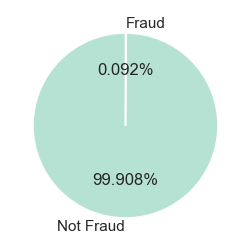

In [228]:
get_class_distribution(df_sample)

**Observation**
- Data imbalance has 5,082,403 Not Fraud and 4,655 Yes Fraud
- Only 0.1% of the transactions were fraud, therefore, we have an highly imbalanced class which will be handle during Feature Engineering part


In [229]:
# Identify categorical and numerical features
categorical_features = []
numerical_features = []
for i in df_raw.columns:
    if df_raw[i].dtype == 'object':
        categorical_features.append(i)  # Append to the list of categorical features
    else:
        numerical_features.append(i)    # Append to the list of numerical features

print(f"Categorical Features : {categorical_features}")
print(f"Numerical Features: {numerical_features}")

Categorical Features : ['Time', 'Amount', 'Use Chip', 'Merchant City', 'Merchant State', 'Errors?', 'Is Fraud?']
Numerical Features: ['User', 'Card', 'Year', 'Month', 'Day', 'Merchant Name', 'Zip', 'MCC']


Univariate Analysis

In [230]:
nonfraud_data = df_sample[df_sample['Is Fraud?'] == 'No']
nonfraud_data.head(2)

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,MCC_Group,Hour,Date,Day of Week
4338,0,0,2017,1,3,28.06,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,NaN,No,Miscellaneous Stores,6,2017-01-03,1
4339,0,0,2017,1,4,46.07,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912,NaN,No,Miscellaneous Stores,6,2017-01-04,2


In [231]:
fraud_data = df_sample[df_sample['Is Fraud?'] == 'Yes']
fraud_data.head(2)

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,MCC_Group,Hour,Date,Day of Week
21659,1,1,2019,5,11,488.00,Chip Transaction,-7807051024009846392,Rome,Italy,100.0,3684,NaN,Yes,Lodging,14,2019-05-11,5
21660,1,1,2019,5,11,14.22,Chip Transaction,9057735476014445185,Rome,Italy,100.0,5311,NaN,Yes,Retail Outlet Services,14,2019-05-11,5


In [232]:
import matplotlib.pyplot as plt
import seaborn as sns

def countplot(input_df, num_feature):
    plt.figure(figsize=(15, 10))
    sns.countplot(data=input_df, x=num_feature)
    plt.title(f'Number of Fraudulent Transactions by {num_feature}')
    plt.show()

def distplot(input_df, num_feature):
    sns.distplot(input_df[num_feature].astype(float), kde=False, bins=80)
    plt.title(f'Distribution of Fraudulent Transaction {num_feature}')
    plt.xlabel(num_feature)
    plt.ylabel('Number of Transactions')
    plt.xlim(-200, 2000)
    plt.show()

In [233]:
def violin_plot(df,x,y):
    sns.set_theme(style="whitegrid", palette="pastel",rc={'figure.figsize': (5, 5)})
    g = sns.catplot(data=df_sample,x=x,col=y,kind='violin')
    g.fig.set_size_inches(10, 3) 

def bar_plot(df,x,y,x_axis=True,fig_size=(8,3)):
    if x_axis==True:
        x_axis = x
        y_axis = y 
    else:
        x_axis = y
        y_axis = x 
    sns.set_theme(style="whitegrid", palette="pastel",rc={'figure.figsize': fig_size})
    df_groupby= df.groupby([y]).mean()
    df_groupby = df_groupby.reset_index()
    g = sns.barplot(data = df_groupby, x=x_axis, y=y_axis)
    # g.fig.set_size_inches(10, 3) 

### 1. Amount

<AxesSubplot: xlabel='Amount', ylabel='Is Fraud?'>

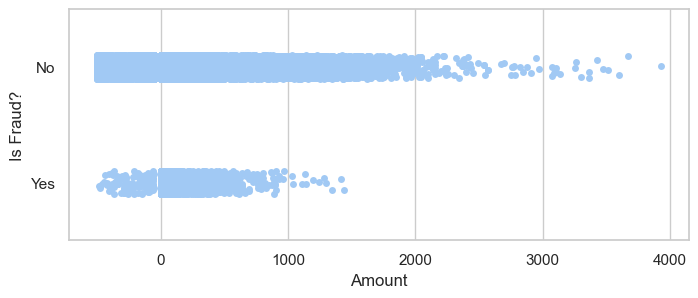

In [234]:
sns.stripplot(data=df_sample,x='Amount',y='Is Fraud?')

_The majority of fraudulent transactions' amount range from 0 to 250, indicating a prevalence of fraud in smaller-value transactions._

### 2. Time

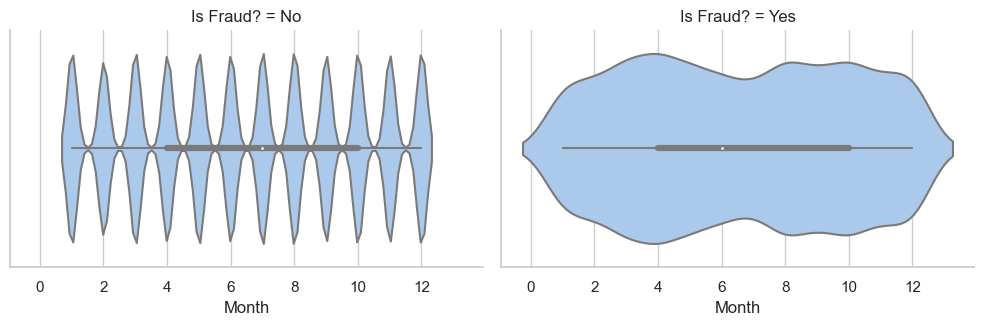

In [235]:
violin_plot(df_sample,'Month','Is Fraud?')

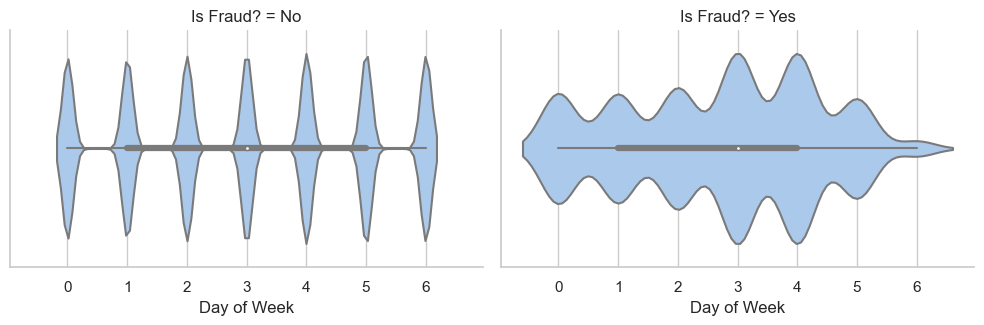

In [236]:
violin_plot(df_sample,'Day of Week','Is Fraud?')

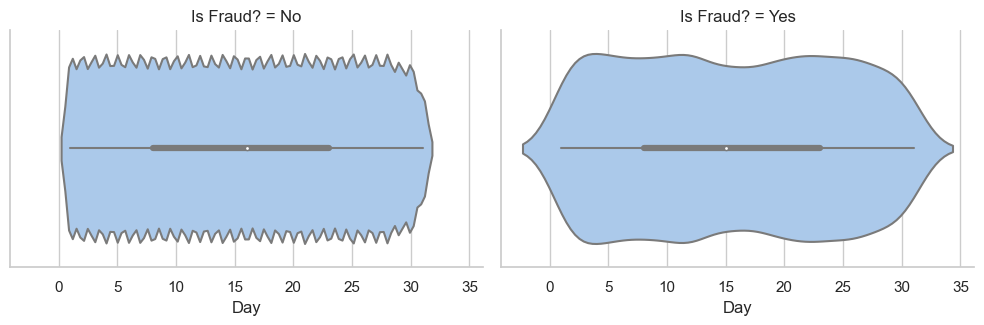

In [237]:
violin_plot(df_sample,'Day','Is Fraud?')

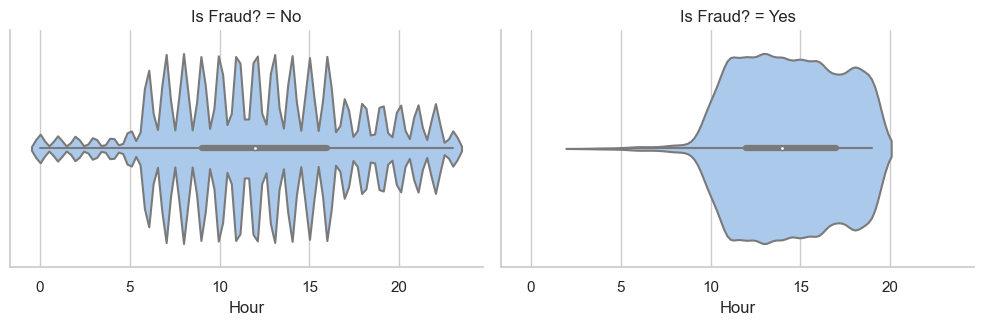

In [238]:
violin_plot(df_sample,'Hour','Is Fraud?')

### Convert Amount to int

In [239]:
# Transform Is Fraud? to 1/0 value (Fraud: 1, Not Fraud: 0)
df_sample["Is Fraud?"] = df_sample["Is Fraud?"].replace({'No': 0, 'Yes': 1})
df_sample.head(2)

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,MCC_Group,Hour,Date,Day of Week
4338,0,0,2017,1,3,28.06,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,NaN,0,Miscellaneous Stores,6,2017-01-03,1
4339,0,0,2017,1,4,46.07,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912,NaN,0,Miscellaneous Stores,6,2017-01-04,2


### 3. Merchant Group

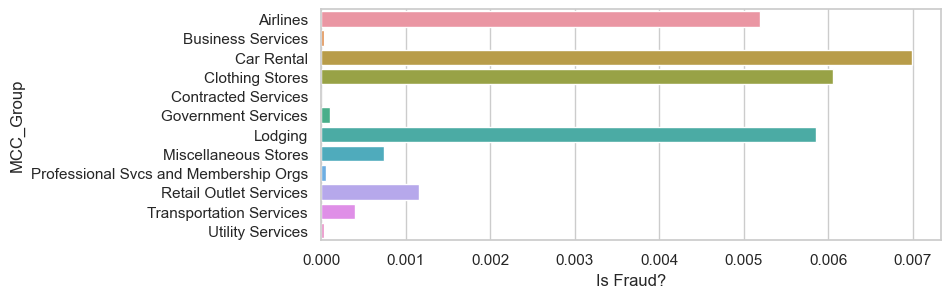

In [240]:
bar_plot(df_sample,'Is Fraud?','MCC_Group')

### 4. Type of transaction

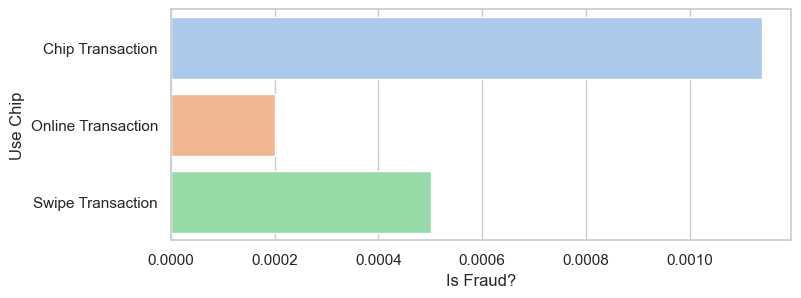

In [241]:
bar_plot(df_sample,'Is Fraud?','Use Chip')

### 5. Type of Card

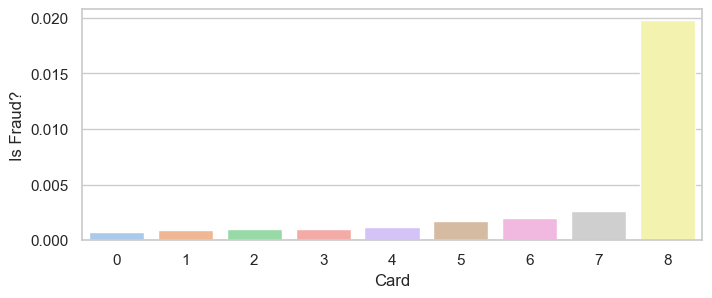

In [242]:
bar_plot(df_sample,'Is Fraud?','Card',False)


### 6. Geographical

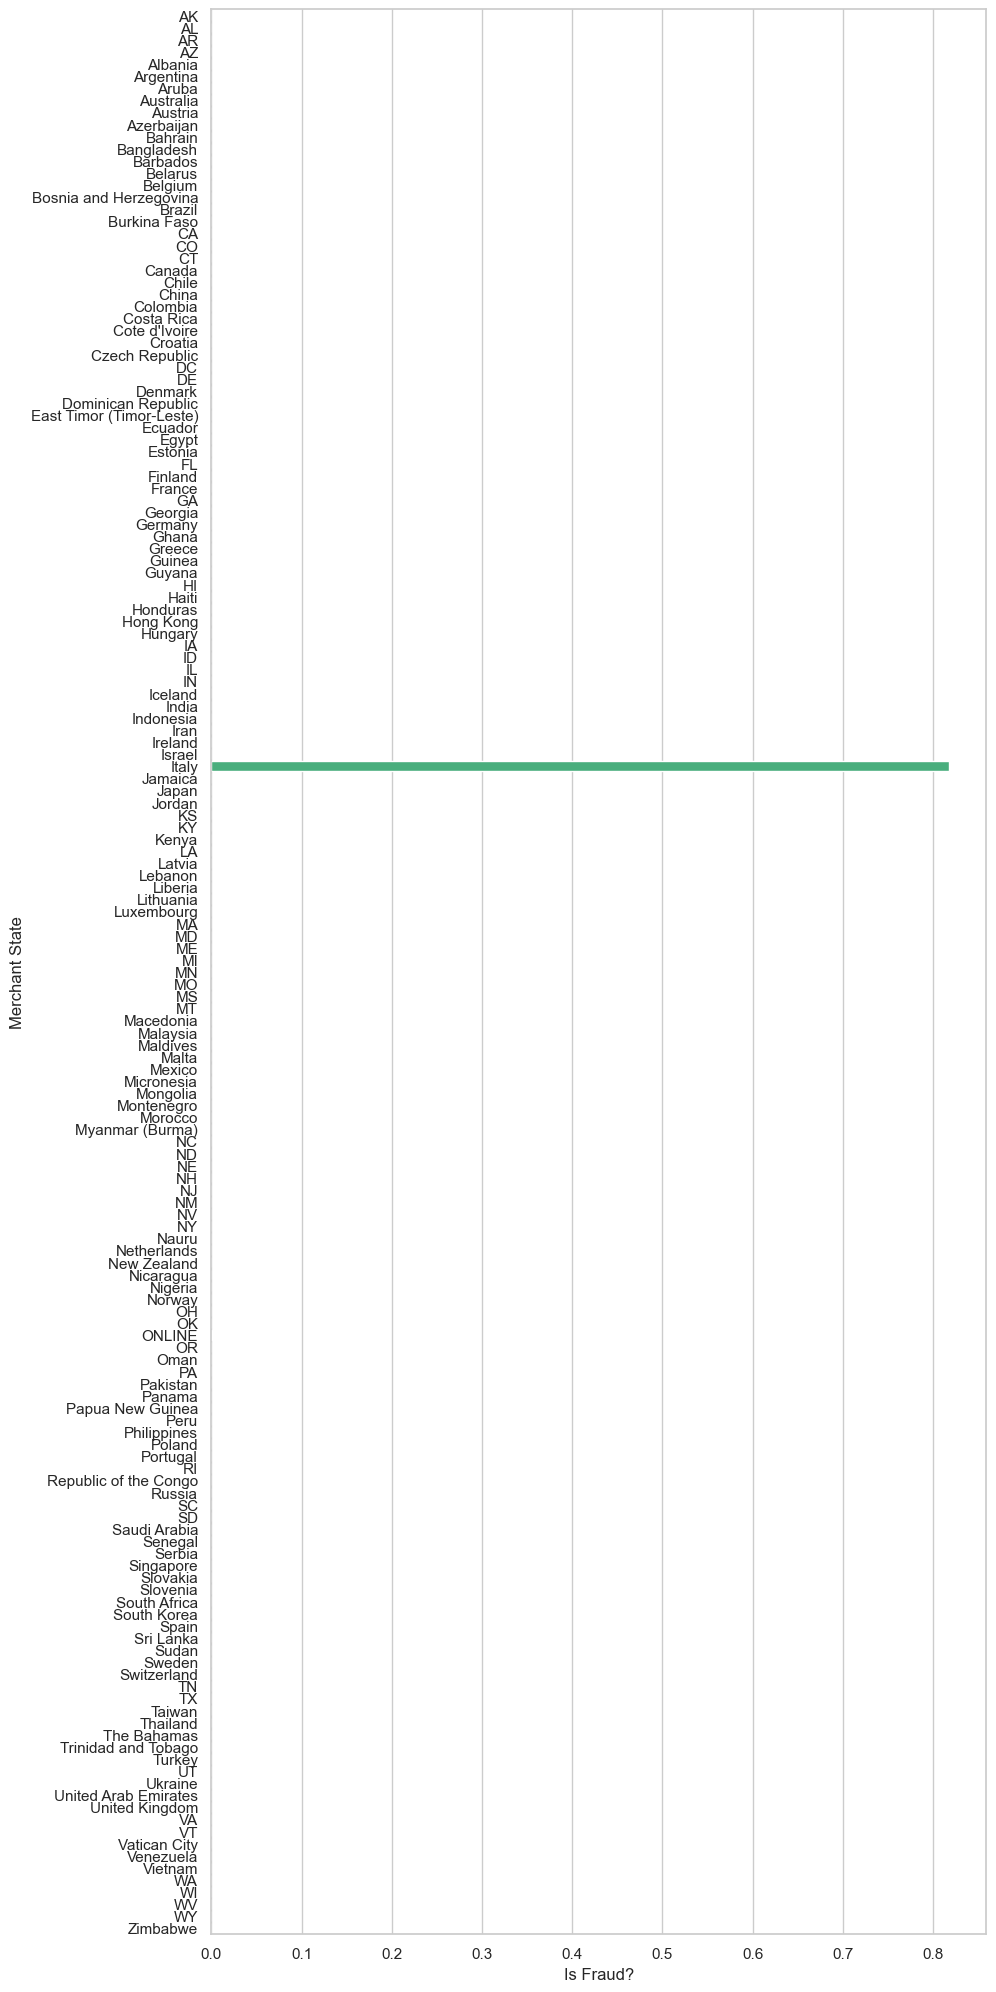

In [243]:
bar_plot(df_sample, 'Is Fraud?','Merchant State',fig_size=(10,25))

In [244]:
print(fraud_data['Merchant State'].value_counts())
print(nonfraud_data['Merchant State'].value_counts())
print(fraud_data['Merchant City'].value_counts())
print(nonfraud_data['Merchant City'].value_counts())

Italy     4507
ONLINE     125
OH          23
Name: Merchant State, dtype: int64
ONLINE                    630990
CA                        535729
TX                        370393
NY                        290727
FL                        273882
                           ...  
Bosnia and Herzegovina         3
Nicaragua                      3
Lithuania                      2
Azerbaijan                     2
Bahrain                        1
Name: Merchant State, Length: 159, dtype: int64
Rome          4507
ONLINE         125
Marion          22
Perrysburg       1
Name: Merchant City, dtype: int64
ONLINE           630990
Houston           51751
Los Angeles       36953
Miami             36411
Brooklyn          31485
                  ...  
Barnard               1
Strausstown           1
Annona                1
Willow                1
Mountain Dale         1
Name: Merchant City, Length: 10547, dtype: int64


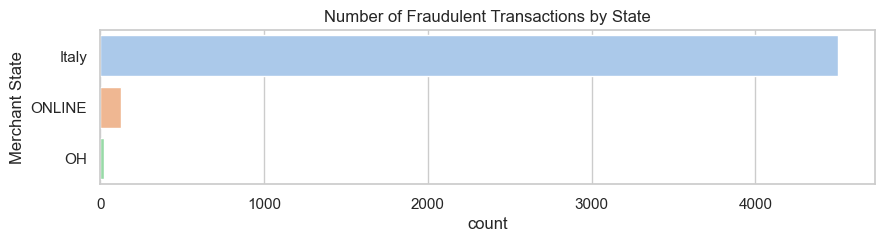

In [245]:
plt.figure(figsize=(10, 2))  
sns.countplot(data=fraud_data, y='Merchant State', order=fraud_data['Merchant State'].value_counts().index)
plt.title('Number of Fraudulent Transactions by State')
plt.show()

In [246]:
fraud_data[fraud_data['Merchant City']=='Rome'].head(2)

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,MCC_Group,Hour,Date,Day of Week
21659,1,1,2019,5,11,488.00,Chip Transaction,-7807051024009846392,Rome,Italy,100.0,3684,NaN,Yes,Lodging,14,2019-05-11,5
21660,1,1,2019,5,11,14.22,Chip Transaction,9057735476014445185,Rome,Italy,100.0,5311,NaN,Yes,Retail Outlet Services,14,2019-05-11,5


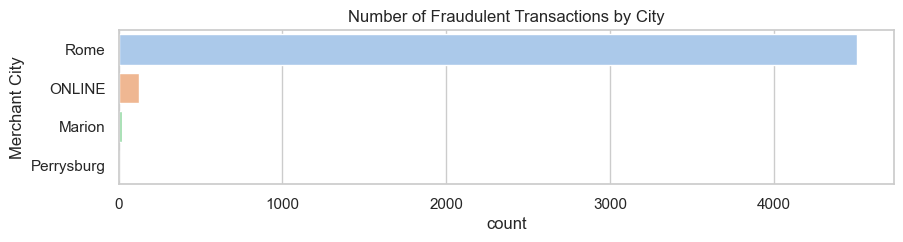

In [247]:
plt.figure(figsize=(10, 2))  
sns.countplot(data=fraud_data, y='Merchant City', order=fraud_data['Merchant City'].value_counts().index)
plt.title('Number of Fraudulent Transactions by City')
plt.show()

In [248]:
# plt.figure(figsize=(10, 500))  
# sns.countplot(data=nonfraud_data, y='Merchant City', order=nonfraud_data['Merchant City'].value_counts().index)
# plt.title('Number of NonFraudulent Transactions by City')
# plt.show()

In [249]:
fraud_data['Zip'].value_counts()

100.0      4507
0.0         125
43302.0      11
43301.0      11
43551.0       1
Name: Zip, dtype: int64

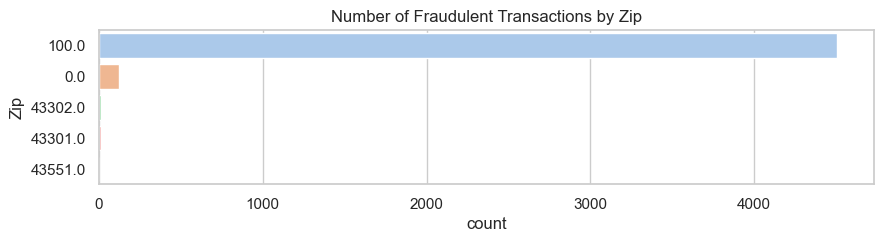

In [250]:
plt.figure(figsize=(10, 2))  
sns.countplot(data=fraud_data, y='Zip', order=fraud_data['Zip'].value_counts().index)
plt.title('Number of Fraudulent Transactions by Zip')
plt.show()

In [251]:
# Then make all local as 20
df_sample['Zip']=np.where(df_sample['Zip']>100,20,df_sample['Zip'])

In [252]:
df_sample['Zip'].value_counts()

20.0     4420111
0.0       631115
100.0      35832
Name: Zip, dtype: int64

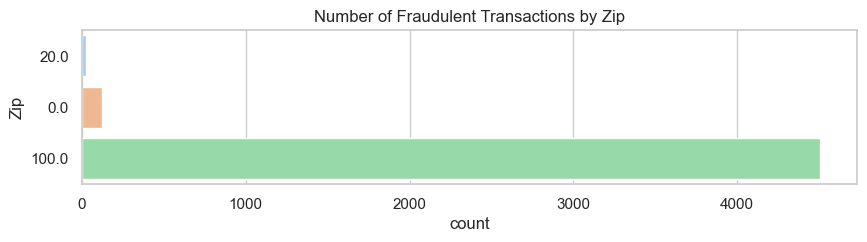

In [253]:
plt.figure(figsize=(10, 2))  
sns.countplot(data=df_sample[df_sample['Is Fraud?']==1], y='Zip', order=df_sample['Zip'].value_counts().index)
plt.title('Number of Fraudulent Transactions by Zip')
plt.show()

### 7. Date and Time

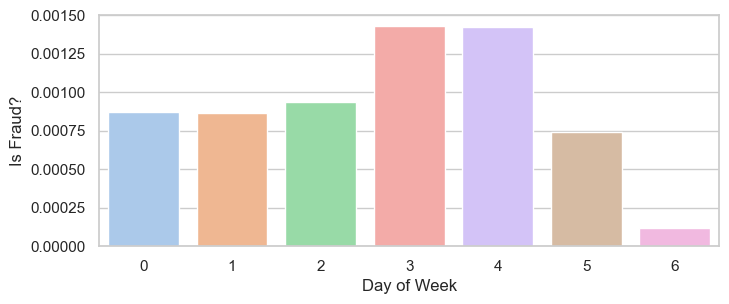

In [254]:
bar_plot(df_sample,'Is Fraud?','Day of Week', False)

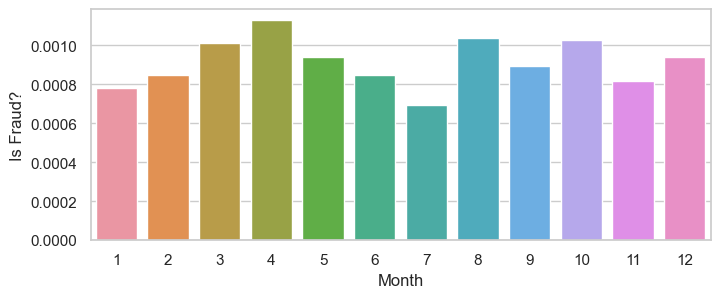

In [255]:
bar_plot(df_sample,'Is Fraud?','Month',False)

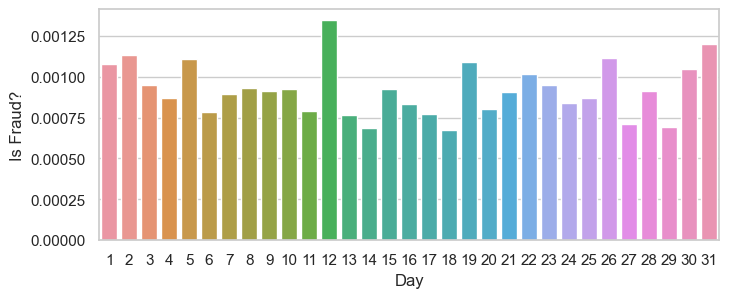

In [256]:
bar_plot(df_sample,'Is Fraud?','Day',False)

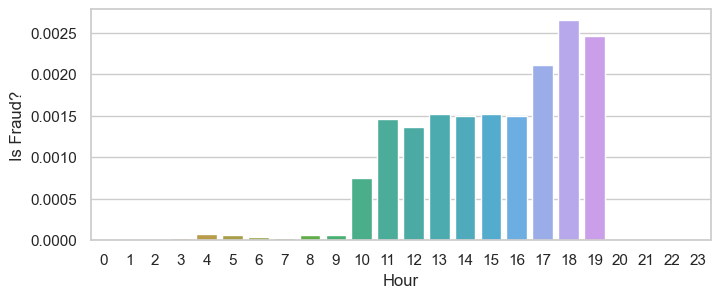

In [257]:
bar_plot(df_sample,'Is Fraud?','Hour',False)

In [258]:
df_sample.dropna(subset=['Day of Week'], inplace=True)

null_mask = df_sample['Day of Week'].isnull()
print(df_sample[null_mask])

df_sample.drop(columns=['Date'], inplace=True)
df_sample.head(2)




Empty DataFrame
Columns: [User, Card, Year, Month, Day, Amount, Use Chip, Merchant Name, Merchant City, Merchant State, Zip, MCC, Errors?, Is Fraud?, MCC_Group, Hour, Date, Day of Week]
Index: []


,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,MCC_Group,Hour,Day of Week
4338,0,0,2017,1,3,28.06,Chip Transaction,-5475680618560174533,Monterey Park,CA,20.0,5942,NaN,0,Miscellaneous Stores,6,1
4339,0,0,2017,1,4,46.07,Chip Transaction,-34551508091458520,La Verne,CA,20.0,5912,NaN,0,Miscellaneous Stores,6,2


----------
## <center> Feature Selection
----------

---------------

## <center> Data Preprocessing Part 2 </center>

--------------


### Drop Null values

In [259]:
getDataSummary(df_sample)

,data_type,count_unique_values,count_null
User,int64,1598,0
Card,int64,9,0
Year,int64,3,0
Month,int64,12,0
Day,int64,31,0
Amount,float64,57358,0
Use Chip,object,3,0
Merchant Name,int64,53778,0
Merchant City,object,10547,0
Merchant State,object,159,0


In [260]:
# Drop columns with null values
feature_baseN='Zip'
feature_drop='Merchant City'
model_data = df_sample.drop([feature_drop,'Errors?'], axis=1) 
model_data.head(2)


,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant State,Zip,MCC,Is Fraud?,MCC_Group,Hour,Day of Week
4338,0,0,2017,1,3,28.06,Chip Transaction,-5475680618560174533,CA,20.0,5942,0,Miscellaneous Stores,6,1
4339,0,0,2017,1,4,46.07,Chip Transaction,-34551508091458520,CA,20.0,5912,0,Miscellaneous Stores,6,2


Drop unnecessary features and features without clear definition
-Merchant city feature importance is too  much
-merchant name (a bit ok)

In [261]:
#gofeature
model_data.drop(['User','Year','Merchant State','Merchant Name','MCC','Use Chip','Card'], axis=1, inplace=True) #, 'Merchant City', 'Card'
model_data.head(2)

,Month,Day,Amount,Zip,Is Fraud?,MCC_Group,Hour,Day of Week
4338,1,3,28.06,20.0,0,Miscellaneous Stores,6,1
4339,1,4,46.07,20.0,0,Miscellaneous Stores,6,2


**Observation:**
- The cleaned model data has ------- observations/rows and ------- variables/columns.

------------

## <center> Data Transformation: Encoding categorical data
----------

In [262]:
model_data.groupby(['MCC_Group']).mean()

,Month,Day,Amount,Zip,Is Fraud?,Hour,Day of Week
MCC_Group,,,,,,,
Airlines,6.405360,15.604067,732.078315,20.394026,0.005190,13.395827,3.109099
Business Services,6.527229,15.724873,57.027891,18.189436,0.000037,13.396990,2.923082
Car Rental,6.572227,15.753811,62.019048,26.504172,0.006989,15.278600,2.619491
Clothing Stores,6.492591,15.789208,61.469069,18.819025,0.006058,12.516125,2.898973
Contracted Services,6.371627,16.085582,145.225189,20.000000,0.000000,11.926754,3.046261
Government Services,6.536275,15.731334,14.747886,19.997830,0.000108,11.969271,3.030105
Lodging,6.527375,15.624107,77.494368,23.909286,0.005857,13.647196,2.581714
Miscellaneous Stores,6.531355,15.720331,35.000411,20.322374,0.000741,12.859924,3.041674
Professional Svcs and Membership Orgs,6.521413,15.710682,189.117488,20.000000,0.000062,12.222894,3.100462


In [263]:
getDataSummary(model_data)

,data_type,count_unique_values,count_null
Month,int64,12,0
Day,int64,31,0
Amount,float64,57358,0
Zip,float64,3,0
Is Fraud?,int64,2,0
MCC_Group,object,12,0
Hour,int32,24,0
Day of Week,int64,7,0


One Hot Encoding for Use Chip - removed not important

In [264]:
# model_data = pd.get_dummies(model_data, columns=['Use Chip'], drop_first=True)

# print(model_data.info())
# model_data.head(3)

In [265]:
# One-hot encoding for MCC Groups
model_data = pd.get_dummies(model_data, columns=['MCC_Group'], drop_first=False)

print(model_data.info())
model_data.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5087058 entries, 4338 to 24386731
Data columns (total 19 columns):
 #   Column                                           Dtype  
---  ------                                           -----  
 0   Month                                            int64  
 1   Day                                              int64  
 2   Amount                                           float64
 3   Zip                                              float64
 4   Is Fraud?                                        int64  
 5   Hour                                             int32  
 6   Day of Week                                      int64  
 7   MCC_Group_Airlines                               uint8  
 8   MCC_Group_Business Services                      uint8  
 9   MCC_Group_Car Rental                             uint8  
 10  MCC_Group_Clothing Stores                        uint8  
 11  MCC_Group_Contracted Services                    uint8  
 12  MCC_Group_

,Month,Day,Amount,Zip,Is Fraud?,Hour,Day of Week,MCC_Group_Airlines,MCC_Group_Business Services,MCC_Group_Car Rental,MCC_Group_Clothing Stores,MCC_Group_Contracted Services,MCC_Group_Government Services,MCC_Group_Lodging,MCC_Group_Miscellaneous Stores,MCC_Group_Professional Svcs and Membership Orgs,MCC_Group_Retail Outlet Services,MCC_Group_Transportation Services,MCC_Group_Utility Services
4338,1,3,28.06,20.0,0,6,1,0,0,0,0,0,0,0,1,0,0,0,0
4339,1,4,46.07,20.0,0,6,2,0,0,0,0,0,0,0,1,0,0,0,0
4340,1,6,31.08,20.0,0,5,4,0,0,0,0,0,0,0,0,0,1,0,0


In [266]:
# # One-hot encoding for Month
# model_data = pd.get_dummies(model_data, columns=['Month'], drop_first=False)

# print(model_data.info())
# model_data.head(3)

Remove not impprtant

In [267]:
# # One-hot encoding for Card
# model_data = pd.get_dummies(model_data, columns=['Card'], drop_first=False)



In [268]:
# One-hot encoding for Day of Week
model_data = pd.get_dummies(model_data, columns=['Day of Week'], drop_first=False)

print(model_data.info())
model_data.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5087058 entries, 4338 to 24386731
Data columns (total 25 columns):
 #   Column                                           Dtype  
---  ------                                           -----  
 0   Month                                            int64  
 1   Day                                              int64  
 2   Amount                                           float64
 3   Zip                                              float64
 4   Is Fraud?                                        int64  
 5   Hour                                             int32  
 6   MCC_Group_Airlines                               uint8  
 7   MCC_Group_Business Services                      uint8  
 8   MCC_Group_Car Rental                             uint8  
 9   MCC_Group_Clothing Stores                        uint8  
 10  MCC_Group_Contracted Services                    uint8  
 11  MCC_Group_Government Services                    uint8  
 12  MCC_Group_

,Month,Day,Amount,Zip,Is Fraud?,Hour,MCC_Group_Airlines,MCC_Group_Business Services,MCC_Group_Car Rental,MCC_Group_Clothing Stores,...,MCC_Group_Retail Outlet Services,MCC_Group_Transportation Services,MCC_Group_Utility Services,Day of Week_0,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Day of Week_5,Day of Week_6
4338,1,3,28.06,20.0,0,6,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4339,1,4,46.07,20.0,0,6,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4340,1,6,31.08,20.0,0,5,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [269]:
# One-hot encoding for Zip
model_data = pd.get_dummies(model_data, columns=['Zip'], drop_first=False)


In [270]:
getDataSummary(model_data)

,data_type,count_unique_values,count_null
Month,int64,12,0
Day,int64,31,0
Amount,float64,57358,0
Is Fraud?,int64,2,0
Hour,int32,24,0
MCC_Group_Airlines,uint8,2,0
MCC_Group_Business Services,uint8,2,0
MCC_Group_Car Rental,uint8,2,0
MCC_Group_Clothing Stores,uint8,2,0
MCC_Group_Contracted Services,uint8,2,0


#### Correlation Heatmap

In [271]:
# # Correlation Heat Map: Pair-wise correlation
# plt.figure(figsize=(20,10))
# sns.heatmap(model_data.corr(), annot=True, cmap='Blues')  #coolwarm
# plt.title('Correlation Matrix')
# plt.show()

<b>Observation: </b>

Weak multicolinearity between all the variables

<br>Reference: https://towardsdatascience.com/eveything-you-need-to-know-about-interpreting-correlations-2c485841c0b8

----------
## <center> Divide to Dependent and Independent Variables
----------

In [272]:
model_data['Hour'].unique()

array([ 6,  5, 13, 20,  9, 10, 16,  7, 12,  0, 14, 11, 17, 21, 19,  8, 15,
        2,  3, 22, 18,  1, 23,  4])

In [273]:
# Assign the Y and X features
y_values = model_data.loc[:, model_data.columns == 'Is Fraud?']
X_values = model_data.loc[:, model_data.columns != 'Is Fraud?']

print('Dependent Variable:')
print(y_values.columns)

print('\nIndependent Variables:',len(X_values.columns))
print(X_values.columns)

Dependent Variable:
Index(['Is Fraud?'], dtype='object')

Independent Variables: 26
Index(['Month', 'Day', 'Amount', 'Hour', 'MCC_Group_Airlines',
       'MCC_Group_Business Services', 'MCC_Group_Car Rental',
       'MCC_Group_Clothing Stores', 'MCC_Group_Contracted Services',
       'MCC_Group_Government Services', 'MCC_Group_Lodging',
       'MCC_Group_Miscellaneous Stores',
       'MCC_Group_Professional Svcs and Membership Orgs',
       'MCC_Group_Retail Outlet Services', 'MCC_Group_Transportation Services',
       'MCC_Group_Utility Services', 'Day of Week_0', 'Day of Week_1',
       'Day of Week_2', 'Day of Week_3', 'Day of Week_4', 'Day of Week_5',
       'Day of Week_6', 'Zip_0.0', 'Zip_20.0', 'Zip_100.0'],
      dtype='object')


----------
## <center> Split Data to TRAIN and TEST
----------

In [274]:
# sampling_method 0 - UNDERSAMPLE
# sampling_method 1 - OVERSAMPLE
# sampling_method 2 - UNDERSAMPLE+OVERSAMPLE

def sample_imbalanced_data(X,y,sampling_method, sampling_strategy=None,k_neighbors=5):
    x_sample,y_sample = X,y
    # categorical_features_idx=[X.columns.get_loc("Day of Week")]
    print(sampling_strategy, k_neighbors)
    match (sampling_method):
        case 0:          
            undersample = RandomUnderSampler(sampling_strategy = sampling_strategy ,random_state=1234)

            # Perform undersampling
            x_sample,y_sample = undersample.fit_resample(X, y)

            print('\nAfter Undersampling\n No. of Observations:',len(y_sample))
            print(y_sample['Is Fraud?'].value_counts() / len(y_sample))
    
        case 1: 
            oversample = SMOTE(random_state=1234,k_neighbors=k_neighbors)

            # Perform oversampling using SMOTE
            x_sample,y_sample = oversample.fit_resample(X, y)

            print('\nAfter Oversampling\n No. of Observations:',len(y_sample))
            print(y_sample['Is Fraud?'].value_counts() / len(y_sample))
       
        case 2: 
            undersample = RandomUnderSampler(sampling_strategy = sampling_strategy ,random_state=1234)

            # Perform undersampling
            x_sample,y_sample = undersample.fit_resample(X, y)

            print('\nAfter Undersampling\n No. of Observations:',len(y_sample))
            print(y_sample['Is Fraud?'].value_counts() / len(y_sample))
    
            oversample = SMOTE(random_state=1234,k_neighbors=k_neighbors) #, categorical_features=categorical_features_idx

            # Perform oversampling using SMOTE
            x_sample,y_sample = oversample.fit_resample(x_sample, y_sample)

            print('\nAfter Oversampling\n No. of Observations:',len(y_sample))
            print(y_sample['Is Fraud?'].value_counts() / len(y_sample))

        case _:
            raise ValueError("That sampling_method is invalid")

    return x_sample, y_sample
    

In [275]:
#gohere
balance_before_split = False
# balance_before_split = True

if balance_before_split:
    class_weight=None
    # # UNDERSAMPLE
    # sampling_method=0
    # sampling_strategy=.42
    # x_oversample, y_oversample = sample_imbalanced_data(X_values,y_values, sampling_method, sampling_strategy=sampling_strategy)
    # min_samples_leaf=10
    # max_depth=18
    # estimators=50
    # samples_leaf_sizes = [2,4,6,8,10,50]
    # tree_depths = range(1,30)
    # class_weight='balanced'
    # execute_crossval=True

    # # # OVERSAMPLE - Best Result
    # sampling_method=1
    # k_neighbors=50
    # x_oversample, y_oversample = sample_imbalanced_data(X_values,y_values, sampling_method,k_neighbors=k_neighbors)
    # min_samples_leaf=500
    # max_depth=13
    # estimators=100
    # samples_leaf_sizes = [500,1000,2000,3000,4000,5000]
    # tree_depths = range(1,20)
    # execute_crossval=False

    # # UNDER+OVERSAMPLE - Best result
    sampling_method=2
    k_neighbors=5
    sampling_strategy=.42
    k_neighbors=10 #10 #20
    x_oversample, y_oversample = sample_imbalanced_data(X_values,y_values, sampling_method, sampling_strategy=sampling_strategy, k_neighbors=k_neighbors)
    min_samples_leaf=10
    max_depth=7
    estimators=25 #50
    samples_leaf_sizes = [2,4,6,7,8,10,50]
    tree_depths = range(1,30)
    execute_crossval=True
    sampling_method=10
    # df = x_oversample.append(y_oversample)
    # get_class_distribution(df)
    class_weight='balanced'
else:
    x_oversample = 0
    y_oversample = 0



In [276]:
# x_oversample.shape, y_oversample.shape, X_values.shape, y_values.shape

In [277]:
#gohere
# Split the data into training (70%) and test (30%) sets

if balance_before_split:
    X_train, X_test, y_train, y_test = train_test_split(x_oversample,y_oversample,test_size=0.3,random_state=1234, stratify=y_oversample)
    x_oversample = X_train
    y_oversample = y_train
else:
    X_train, X_test, y_train, y_test = train_test_split(X_values,y_values,test_size=0.3,random_state=1234, stratify=y_values)

print('X Train:',X_train.shape)
print('Y Train:',y_train.shape)
print('X Test:',X_test.shape)
print('Y Test:',y_test.shape)
X_train.head()

X Train: (3560940, 26)
Y Train: (3560940, 1)
X Test: (1526118, 26)
Y Test: (1526118, 1)


,Month,Day,Amount,Hour,MCC_Group_Airlines,MCC_Group_Business Services,MCC_Group_Car Rental,MCC_Group_Clothing Stores,MCC_Group_Contracted Services,MCC_Group_Government Services,...,Day of Week_0,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Day of Week_5,Day of Week_6,Zip_0.0,Zip_20.0,Zip_100.0
14096851,6,6,111.96,6,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1569080,2,8,11.16,10,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2314036,3,31,40.06,21,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4196337,9,5,67.20,19,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2037395,8,6,5.05,8,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [278]:
# df_test = X_test.append(y_test)
# get_class_distribution(df_test)

In [279]:
# df_train = X_train.append(y_train)
# get_class_distribution(df_train)

----------
## <center> Feature Engineering
----------

## Handling Imbalanced Data

## Undersampling/Oversampling

In [280]:
# gohere choose out of the following samplings

if not(balance_before_split):
    # Try without balancing at all and check  performance and confusion matrix

    # Try with balancing of test data (just check if precision is ok)

    # When doing undersampling, make sure for weighted training in Decision Tree Algo
    # When doing oversampling, make sure experiment on nearest neighbors parameter on SMOTE


    class_weight=None
    k_neighbors=5
    execute_crossval=False

    # ---------------------------------
    # NO BALANCING
    x_oversample, y_oversample = X_train,y_train
    print('\n NO Oversampling\n No. of Observations:',len(y_oversample))
    print(y_oversample['Is Fraud?'].value_counts() / len(y_oversample))
    min_samples_leaf=500
    max_depth=7
    estimators=50
    samples_leaf_sizes = [2,4,6,7,8,10,20,30,40,50]
    tree_depths = range(1,15)
    # class_weight='balanced'
    class_weight= {0:.07,1:.93}#{0:.01,1:.99} 
    execute_crossval=False


    # # ------------------------------------------------------------------------------------------------------------
    # # UNDERSAMPLE - Most efficient with still high accuracy
    # sampling_method=0
    # sampling_strategy=.42
    # x_oversample, y_oversample = sample_imbalanced_data(X_train,y_train, sampling_method, sampling_strategy=sampling_strategy)
    # min_samples_leaf=10
    # max_depth=9
    # estimators=50
    # samples_leaf_sizes = [2,4,10,20,30,40,50]
    # tree_depths = range(3,12)
    # # class_weight='balanced'
    # class_weight={0:.3,1:.7}
    # execute_crossval=False

    # # ------------------------------------------------------------------------------------------------------------
    # # OVERSAMPLE
    # sampling_method=1
    # k_neighbors=10    #5
    # x_oversample, y_oversample = sample_imbalanced_data(X_train,y_train, sampling_method,k_neighbors=k_neighbors)
    # min_samples_leaf=500
    # max_depth=10
    # estimators=100
    # samples_leaf_sizes = [50,500,1000,2000,4000]
    # tree_depths = range(13,16)
    # execute_crossval=False

    # # ------------------------------------------------------------------------------------------------------------
    # # UNDER+OVERSAMPLE
    # sampling_method=2
    # sampling_strategy=.42
    # k_neighbors=5 #10 #20
    # x_oversample, y_oversample = sample_imbalanced_data(X_train,y_train, sampling_method, sampling_strategy=sampling_strategy, k_neighbors=k_neighbors)
    # min_samples_leaf=10
    # max_depth=10 #15(no month encode) #22 (for month encoded)
    # estimators=200 #50
    # samples_leaf_sizes = [2,4,10,20,30,40,50]
    # tree_depths = range(1,35)
    # execute_crossval=False




# 1. Sampling strategy recommended the most for the case of imabalnced data 99.9% | .1%
# [] oversampling - check smote parameter k neighbors

# 2. Whats our criteria for overfit?
# check overfitting:
# accuracy x epoch train and test splots
# loss x epoch train and test plots

# 3. The focus is on accuracy and recall but still Is the precision of  <.01 acceptable? in real life?
# ---- compare the confusion matrix 

# ideal scenario -
# actual scenario -

# 4. Performance metrics
# - (for hihgly imbalance focus on auc)

# *weighted training
# DecisionTreeClassifier(class_weight)~ give more weight to minority class
# - with original imbalance
# then with undersampling



 NO Oversampling
 No. of Observations: 3560940
0    0.999085
1    0.000915
Name: Is Fraud?, dtype: float64


In [281]:
x_oversample.head()

,Month,Day,Amount,Hour,MCC_Group_Airlines,MCC_Group_Business Services,MCC_Group_Car Rental,MCC_Group_Clothing Stores,MCC_Group_Contracted Services,MCC_Group_Government Services,...,Day of Week_0,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Day of Week_5,Day of Week_6,Zip_0.0,Zip_20.0,Zip_100.0
14096851,6,6,111.96,6,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1569080,2,8,11.16,10,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2314036,3,31,40.06,21,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4196337,9,5,67.20,19,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2037395,8,6,5.05,8,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [282]:
getDataSummary(x_oversample)

,data_type,count_unique_values,count_null
Month,int64,12,0
Day,int64,31,0
Amount,float64,50888,0
Hour,int32,24,0
MCC_Group_Airlines,uint8,2,0
MCC_Group_Business Services,uint8,2,0
MCC_Group_Car Rental,uint8,2,0
MCC_Group_Clothing Stores,uint8,2,0
MCC_Group_Contracted Services,uint8,2,0
MCC_Group_Government Services,uint8,2,0


----------
## <center> Decision Tree
----------

### K-Fold Cross Validation
- Use K-Fold Cross Validation on the training set to identify the optimal depth of the tree. The minimum leaf size is set to 500.
- The decision tree is evaluated on imbalanced dataset with SMOTE oversampling
- This step uses RepeatedStratifiedKFold which repeats the cross-validation procedure n times for a more accurate estimate of model performance

In [283]:
def choose_pipeline(sampling_method, depth, class_weight, sampling_strategy):
        tree_model = DecisionTreeClassifier(random_state = 1234, min_samples_leaf=1, max_depth=depth,class_weight=class_weight)
        print(sampling_method, class_weight, sampling_strategy)
        match (sampling_method):
            case 0:
                steps = [('under', RandomUnderSampler(sampling_strategy = sampling_strategy ,random_state=1234)),('model', tree_model)]
            case 1:
                steps = [('over', SMOTE(random_state=1234,k_neighbors=k_neighbors)),('model', tree_model)]
            case 2:
                steps = [('under', RandomUnderSampler(sampling_strategy = sampling_strategy ,random_state=1234)), ('over', SMOTE(random_state=1234,k_neighbors=k_neighbors)),('model', tree_model)]
            case 10:
                steps = [('model', tree_model)]


        return steps, tree_model


In [284]:
sampling_method=10
sampling_strategy=.42

In [285]:
# Fitting trees on the training data using cross-validation
def CrossValidation_DecisionTree(X, y, tree_depths, scoring, sampling_method,class_weight,sampling_strategy):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1234)
    scores_list = []
    scores_std = []
    scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        # tree_model = DecisionTreeClassifier(random_state = 1234, min_samples_leaf=1, max_depth=depth,class_weight=class_weight)
        steps, tree_model= choose_pipeline(sampling_method, depth,class_weight,sampling_strategy)
        pipeline = Pipeline(steps=steps)
        cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)       
        scores_list.append(cv_scores)
        scores_mean.append(cv_scores.mean())
        scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    scores_mean = np.array(scores_mean)
    scores_std = np.array(scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return scores_mean, scores_std, accuracy_scores
  
# Plotting cross-validation results
def CrossValidationPlot_DecisionTree(depths, scores_mean, scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, scores_mean, '-o', label='average cross-validation accuracy (test accuracy)', alpha=0.9)
    ax.fill_between(depths, scores_mean-2*scores_std, scores_mean+2*scores_std, alpha=0.2)
    ax.plot(depths, accuracy_scores, '-*', label='training accuracy', alpha=0.9)
    ax.set_title(title + ' per Tree Depth', fontsize=16)
    ax.set_xlabel('Tree Depth', fontsize=13)
    ax.set_ylabel(title, fontsize=13)
    ax.set_ylim(0,1)
    ax.set_xticks(depths)
    ax.legend()

# Depths to be run
if execute_crossval:
    # Cross-validation Results: mean, stdev, accuracy
    scores_mean_accuracy, scores_std_accuracy, accuracy_scores = CrossValidation_DecisionTree(X_train, y_train, tree_depths, scoring='accuracy',sampling_method=sampling_method,class_weight=class_weight,sampling_strategy=sampling_strategy)
    scores_mean_recall, scores_std_recall, recall_scores = CrossValidation_DecisionTree(X_train, y_train, tree_depths, scoring='recall',sampling_method=sampling_method,class_weight=class_weight,sampling_strategy=sampling_strategy)
    scores_mean_precision, scores_std_precision, precision_scores = CrossValidation_DecisionTree(X_train, y_train, tree_depths, scoring='precision',sampling_method=sampling_method,class_weight=class_weight,sampling_strategy=sampling_strategy)
    scores_mean_roc_auc, scores_std_roc_auc, roc_auc_scores = CrossValidation_DecisionTree(X_train, y_train, tree_depths, scoring='roc_auc',sampling_method=sampling_method,class_weight=class_weight,sampling_strategy=sampling_strategy)
        

    # Plot results
    CrossValidationPlot_DecisionTree(tree_depths, scores_mean_accuracy, scores_std_accuracy, accuracy_scores, 'Accuracy Score')
    CrossValidationPlot_DecisionTree(tree_depths, scores_mean_recall, scores_std_recall, recall_scores, 'Recall Score')
    CrossValidationPlot_DecisionTree(tree_depths, scores_mean_precision, scores_std_precision, precision_scores, 'Precision Score')
    CrossValidationPlot_DecisionTree(tree_depths, scores_mean_roc_auc, scores_std_roc_auc, roc_auc_scores, 'ROC AUC Score')

**Observation:**
- Based on the graphs, it seems that depth of 7 or 8 has the good combination of accuracy and recall.

In [286]:
# Fitting trees on the training data using cross-validation
def CrossValidation_DecisionTree(X, y, samples_leaf_sizes, scoring, sampling_method, class_weight,sampling_strategy):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1234)
    scores_list = []
    scores_std = []
    scores_mean = []
    accuracy_scores = []
    for leaf_size in samples_leaf_sizes:
        # tree_model = DecisionTreeClassifier(random_state = 1234, min_samples_leaf=leaf_size, max_depth=20, class_weight=class_weight)
        steps, tree_model= choose_pipeline(sampling_method, depth=20, class_weight=class_weight,sampling_strategy=sampling_strategy)
        pipeline = Pipeline(steps=steps)
        
        pipeline = Pipeline(steps=steps)
        cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)       
        scores_list.append(cv_scores)
        scores_mean.append(cv_scores.mean())
        scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    scores_mean = np.array(scores_mean)
    scores_std = np.array(scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return scores_mean, scores_std, accuracy_scores
  
# Plotting cross-validation results
def CrossValidationPlot_DecisionTree(samples_leaf_sizes, scores_mean, scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(samples_leaf_sizes, scores_mean, '-o', label='average cross-validation accuracy (test accuracy)', alpha=0.9)
    ax.fill_between(samples_leaf_sizes, scores_mean-2*scores_std, scores_mean+2*scores_std, alpha=0.2)
    ax.plot(samples_leaf_sizes, accuracy_scores, '-*', label='training accuracy', alpha=0.9)
    ax.set_title(title + ' per Min Leaf Size', fontsize=16)
    ax.set_xlabel('Min Leaf Size', fontsize=13)
    ax.set_ylabel(title, fontsize=13)
    ax.set_ylim(0,1)
    ax.set_xticks(samples_leaf_sizes)
    ax.legend()

if execute_crossval:
    # Cross-validation Results: mean, stdev, accuracy
    scores_mean_accuracy, scores_std_accuracy, accuracy_scores = CrossValidation_DecisionTree(X_train, y_train, samples_leaf_sizes, scoring='accuracy',sampling_method=sampling_method,class_weight=class_weight,sampling_strategy=sampling_strategy)
    scores_mean_recall, scores_std_recall, recall_scores = CrossValidation_DecisionTree(X_train, y_train, samples_leaf_sizes, scoring='recall',sampling_method=sampling_method,class_weight=class_weight,sampling_strategy=sampling_strategy)
    scores_mean_precision, scores_std_precision, precision_scores = CrossValidation_DecisionTree(X_train, y_train, samples_leaf_sizes, scoring='precision',sampling_method=sampling_method,class_weight=class_weight,sampling_strategy=sampling_strategy)
        
    # Plot results
    CrossValidationPlot_DecisionTree(samples_leaf_sizes, scores_mean_accuracy, scores_std_accuracy, accuracy_scores, 'Accuracy Score')
    CrossValidationPlot_DecisionTree(samples_leaf_sizes, scores_mean_recall, scores_std_recall, recall_scores, 'Recall Score')
    CrossValidationPlot_DecisionTree(samples_leaf_sizes, scores_mean_precision, scores_std_precision, precision_scores, 'Precision Score')

----------
## Model Training
----------

PCA

In [287]:
# from sklearn.decomposition import PCA
# pca = PCA()

# x_oversample_pca = pca.fit_transform(x_oversample)
# X_test_pca = pca.fit_transform(X_test)

# min_samples_leaf=10
# max_depth=7
# # Fit decision tree model

# model_dtree = DecisionTreeClassifier(random_state = 1234, min_samples_leaf=min_samples_leaf, max_depth=max_depth, class_weight=class_weight)
# model_dtree.fit(x_oversample_pca, y_oversample)

# # Predict the values of y in both the training and test datasets
# # predict() is used to predict the class labels (1/0)
# y_pred_train_dtree = model_dtree.predict(x_oversample_pca)
# y_pred_test_dtree = model_dtree.predict(X_test_pca)

# # predict_proba() is used to output probability estimates
# y_pred_train_prob_dtree = model_dtree.predict_proba(x_oversample_pca)
# y_pred_test_prob_dtree = model_dtree.predict_proba(X_test_pca)

no PCA

In [288]:
# Fit decision tree model

model_dtree = DecisionTreeClassifier(random_state = 1234, min_samples_leaf=min_samples_leaf, max_depth=max_depth, class_weight=class_weight)
model_dtree.fit(x_oversample, y_oversample)

# Predict the values of y in both the training and test datasets
# predict() is used to predict the class labels (1/0)
y_pred_train_dtree = model_dtree.predict(x_oversample)
y_pred_test_dtree = model_dtree.predict(X_test)

# predict_proba() is used to output probability estimates
y_pred_train_prob_dtree = model_dtree.predict_proba(x_oversample)
y_pred_test_prob_dtree = model_dtree.predict_proba(X_test)

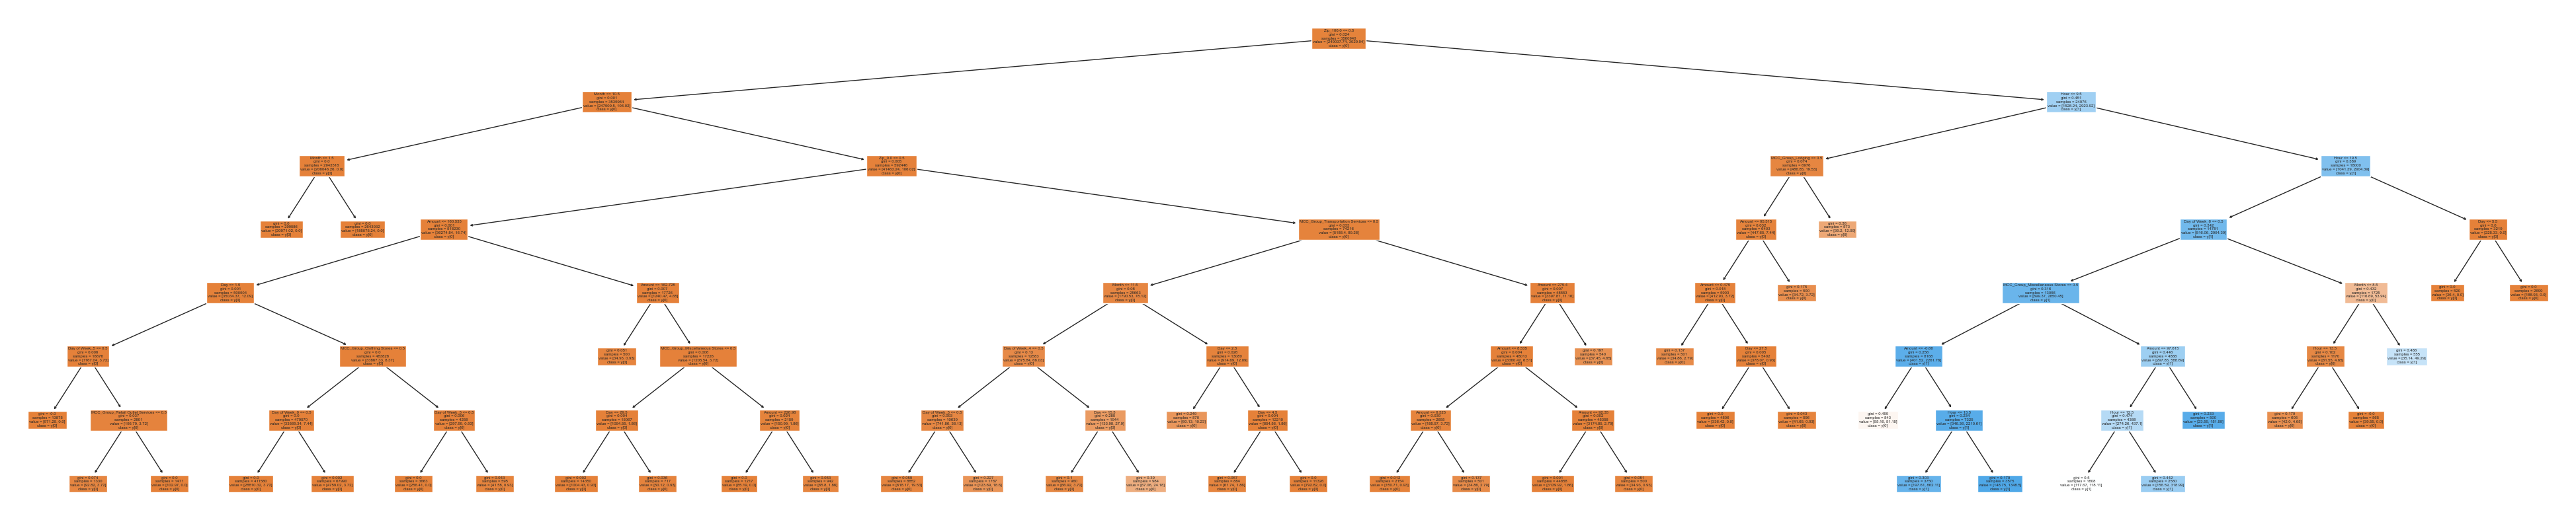

In [289]:
# Plot decision tree
fig = plt.figure(figsize = (50, 10))
tree.plot_tree(model_dtree, feature_names = list(x_oversample.columns), class_names = True, filled = True)
plt.show()

In [290]:
x_oversample.columns

Index(['Month', 'Day', 'Amount', 'Hour', 'MCC_Group_Airlines',
       'MCC_Group_Business Services', 'MCC_Group_Car Rental',
       'MCC_Group_Clothing Stores', 'MCC_Group_Contracted Services',
       'MCC_Group_Government Services', 'MCC_Group_Lodging',
       'MCC_Group_Miscellaneous Stores',
       'MCC_Group_Professional Svcs and Membership Orgs',
       'MCC_Group_Retail Outlet Services', 'MCC_Group_Transportation Services',
       'MCC_Group_Utility Services', 'Day of Week_0', 'Day of Week_1',
       'Day of Week_2', 'Day of Week_3', 'Day of Week_4', 'Day of Week_5',
       'Day of Week_6', 'Zip_0.0', 'Zip_20.0', 'Zip_100.0'],
      dtype='object')

In [291]:
# Summary of Decision Tree Features 
dtree_summary = pd.DataFrame()
dtree_summary['Feature'] = x_oversample.columns
dtree_summary['Feature Importance'] = model_dtree.feature_importances_
dtree_summary = dtree_summary[dtree_summary['Feature Importance']>0]
# dtree_summary
dtree_summary.sort_values(by=['Feature Importance'],ascending=False)

,Feature,Feature Importance
25,Zip_100.0,8.005530e-01
3,Hour,1.518291e-01
22,Day of Week_6,1.639884e-02
2,Amount,1.065494e-02
11,MCC_Group_Miscellaneous Stores,9.701463e-03
0,Month,5.830484e-03
1,Day,1.369079e-03
10,MCC_Group_Lodging,9.426354e-04
20,Day of Week_4,8.683847e-04
14,MCC_Group_Transportation Services,7.615400e-04


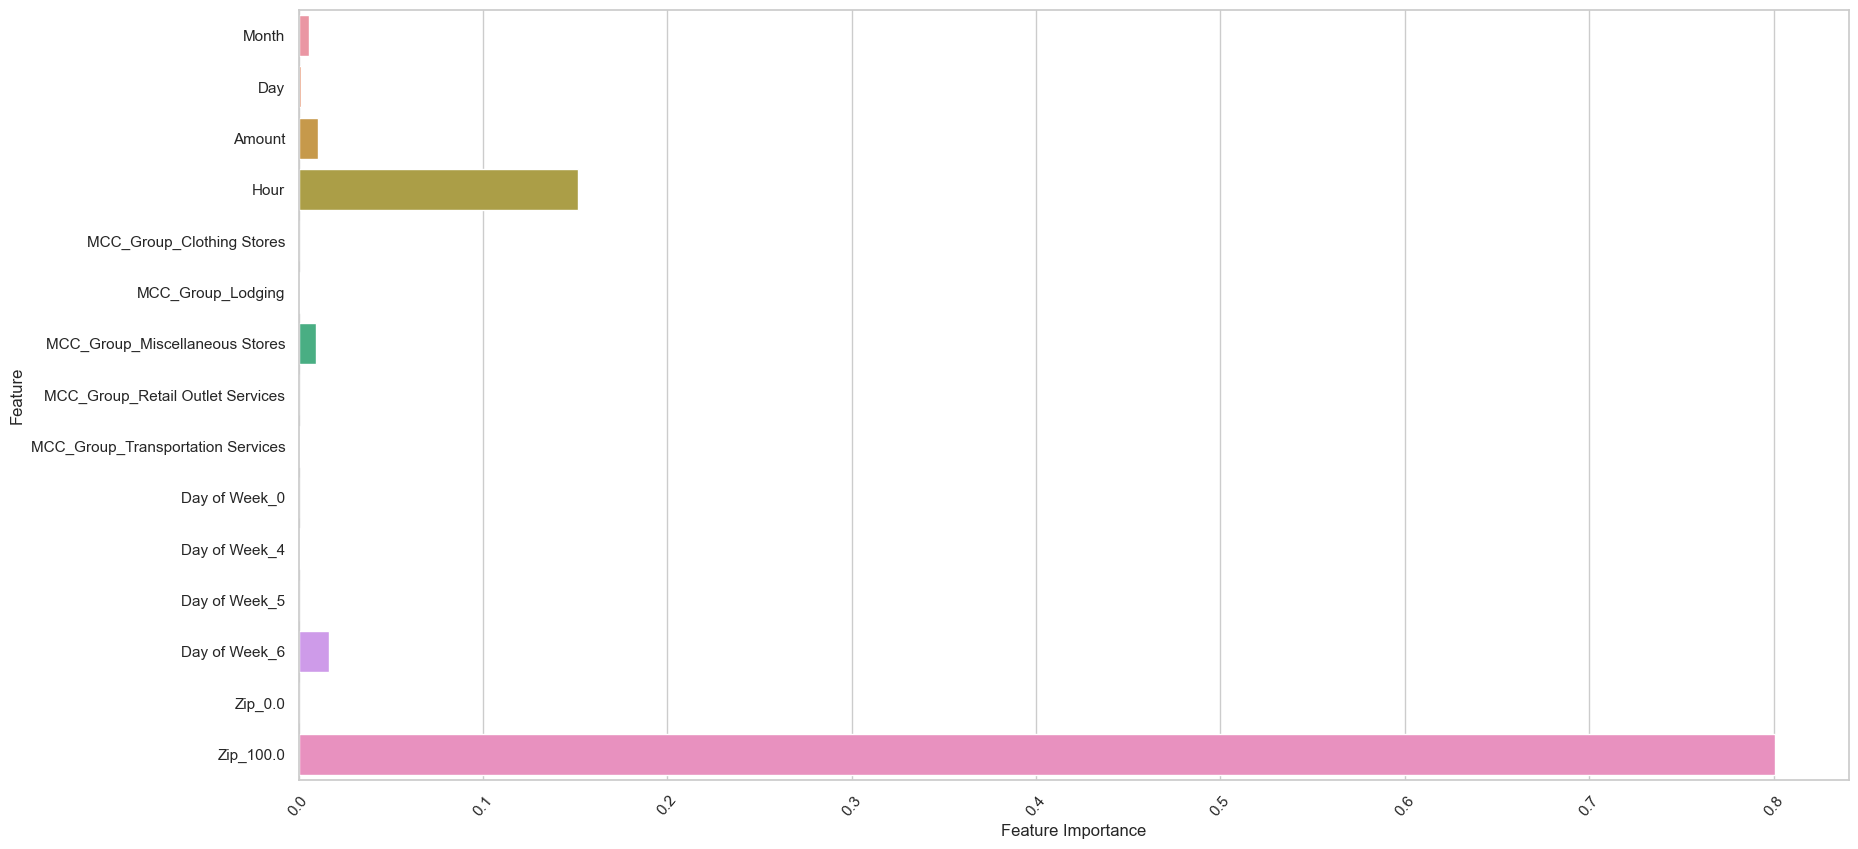

In [292]:
# Plot feature importance
fig = plt.figure(figsize = (20, 10))
sns.barplot(x=dtree_summary['Feature Importance'], y=dtree_summary['Feature'])
plt.xticks(rotation = 50)
plt.show()

----------
## <center> Model Evaluation
----------

In [293]:
# Create a summary of model scores
model_score_list = ['classification accuracy', 
                    'precision', 
                    'recall', 
                    'f1 score',  
                    'ROC AUC',]

model_score = pd.DataFrame(pd.Series(model_score_list))
model_score.set_index(0, inplace=True)
# model_score

In [294]:
def get_perf_metrics(y_train_actual, y_pred_train, y_test_actual, y_test_pred, model_algo_name):
    isTrainData = True
    print(f"{model_algo_name}\n")
    for sample_data in list([[y_train_actual, y_pred_train], [y_test_actual, y_test_pred]]):
        y_dtree = sample_data[0]
        y_pred = sample_data[1]

        rowIndex = model_score.index[0]
        model_score.loc[rowIndex, '1 - Yes'] = np.nan
        model_score.loc[rowIndex, '0 - No'] = np.nan
        model_score.loc[rowIndex, 'weighted ave'] =accuracy_score(y_dtree, y_pred).round(2)
        model_score

        rowIndex = model_score.index[1] 
        model_score.loc[rowIndex, '1 - Yes'] = precision_score(y_dtree,y_pred, pos_label=1).round(2)
        model_score.loc[rowIndex, '0 - No'] = precision_score(y_dtree,y_pred, pos_label=0).round(2)
        model_score.loc[rowIndex, 'weighted ave'] = precision_score(y_dtree,y_pred, average='weighted').round(2)

        rowIndex = model_score.index[2]
        model_score.loc[rowIndex, '1 - Yes'] = recall_score(y_dtree,y_pred, pos_label=1).round(2)
        model_score.loc[rowIndex, '0 - No'] = recall_score(y_dtree,y_pred, pos_label=0).round(2)
        model_score.loc[rowIndex, 'weighted ave'] = recall_score(y_dtree,y_pred, average='weighted').round(2)

        rowIndex = model_score.index[3]
        model_score.loc[rowIndex, '1 - Yes'] = f1_score(y_dtree,y_pred, pos_label=1).round(2)
        model_score.loc[rowIndex, '0 - No'] = f1_score(y_dtree,y_pred, pos_label=0).round(2)
        model_score.loc[rowIndex, 'weighted ave'] = f1_score(y_dtree,y_pred, average='weighted').round(2)

        rowIndex = model_score.index[4]
        model_score.loc[rowIndex, '1 - Yes'] = roc_auc_score(y_dtree,y_pred).round(2)
        model_score.loc[rowIndex, '0 - No'] = roc_auc_score(y_dtree,y_pred).round(2)
        model_score.loc[rowIndex, 'weighted ave'] = roc_auc_score(y_dtree,y_pred, average='weighted').round(2)


        if isTrainData:
            model_score.index.name = 'TRAIN Model Score'
        else:
            model_score.index.name = 'TEST Model Score'

        display(model_score)
        isTrainData =  False


In [295]:
#goresult
get_perf_metrics(y_oversample, y_pred_train_dtree, y_test, y_pred_test_dtree, 'DECISION TREE')


DECISION TREE



,1 - Yes,0 - No,weighted ave
TRAIN Model Score,,,
classification accuracy,NaN,NaN,1.00
precision,0.24,1.00,1.00
recall,0.94,1.00,1.00
f1 score,0.38,1.00,1.00
ROC AUC,0.97,0.97,0.97


,1 - Yes,0 - No,weighted ave
TEST Model Score,,,
classification accuracy,NaN,NaN,1.00
precision,0.24,1.00,1.00
recall,0.95,1.00,1.00
f1 score,0.38,1.00,1.00
ROC AUC,0.97,0.97,0.97


In [296]:
y_test.shape

(1526118, 1)

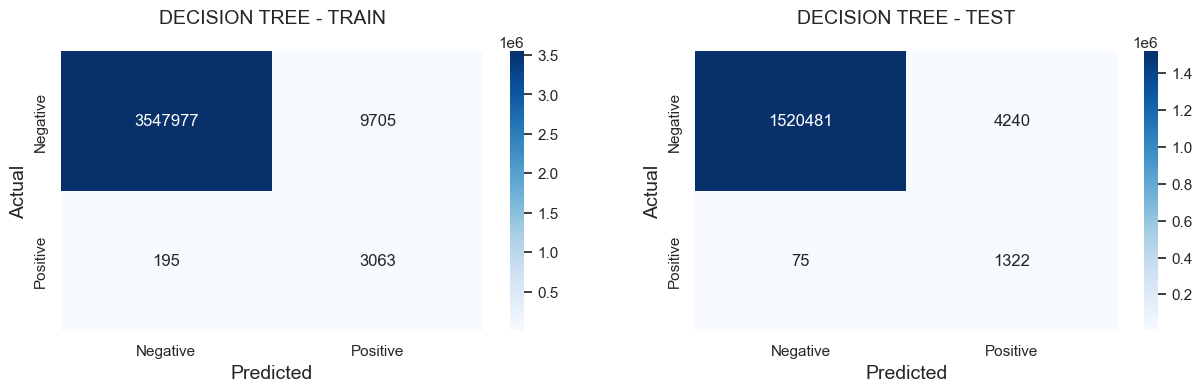

In [297]:
def gen_confusion_matrix(algo, train_y_actual, train_y_pred, test_y_actual, test_y_pred):
    # Order of the input parameters is important: 
    # 1st parameter - actual values
    # 2nd parameter - predicted values
    conf_matrix_train = confusion_matrix(train_y_actual, train_y_pred)
    conf_matrix_test = confusion_matrix(test_y_actual, test_y_pred)


    # Plot Confusion Matrix TRAIN

    plt.figure(figsize=(15,8))

    ax = plt.subplot(2, 2, 1)
    ax = sns.heatmap(conf_matrix_train, annot=True, fmt='d',cmap="Blues")
    # set x-axis label and ticks. 
    ax.set_xlabel("Predicted", fontsize=14)
    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    # set y-axis label and ticks
    ax.set_ylabel("Actual", fontsize=14)
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    # set plot title
    ax.set_title(f"{algo} - TRAIN", fontsize=14, pad=20)


    # Plot Confusion Matrix TEST
    ax = plt.subplot(2, 2, 2)
    ax = sns.heatmap(conf_matrix_test, annot=True, fmt='d',cmap="Blues")
    # set x-axis label and ticks. 
    ax.set_xlabel("Predicted", fontsize=14)
    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    # set y-axis label and ticks
    ax.set_ylabel("Actual", fontsize=14)
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    # set plot title
    ax.set_title(f"{algo} - TEST", fontsize=14, pad=20)
    plt.show()
    
gen_confusion_matrix('DECISION TREE',train_y_actual=y_oversample, train_y_pred=y_pred_train_dtree, test_y_actual=y_test, test_y_pred=y_pred_test_dtree)

-----

# <center>Random Forest

-------


In [298]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# scores =[]
# for k in range(1, 200):
#     rfc = RandomForestClassifier(n_estimators=k)
#     rfc.fit(x_train, y_train)
#     y_pred = rfc.predict(x_test)
#     scores.append(accuracy_score(y_test, y_pred))

# import matplotlib.pyplot as plt
# %matplotlib inline

# # plot the relationship between K and testing accuracy
# # plt.plot(x_axis, y_axis)
# plt.plot(range(1, 200), scores)
# plt.xlabel('Value of n_estimators for Random Forest Classifier')
# plt.ylabel('Testing Accuracy')

In [299]:
# # Modeling with Random Forest
# from sklearn.ensemble import RandomForestClassifier
# class_weight=class_weight
# estimators=200
# max_depth=7
# model_rf = RandomForestClassifier(n_estimators=estimators, random_state=42,  min_samples_leaf=min_samples_leaf, max_depth=max_depth, class_weight=class_weight)
# model_rf.fit(x_oversample, y_oversample)

# y_pred_train_rf = model_rf.predict(x_oversample)
# y_pred_test_rf = model_rf.predict(X_test)

# print("Random Forest Classifier Results:")

In [300]:
# get_perf_metrics(y_oversample, y_pred_train_rf, y_test, y_pred_test_rf, "RANDOM FOREST")

In [301]:
# gen_confusion_matrix('RANDOM FOREST',train_y_actual=y_oversample, train_y_pred=y_pred_train_rf, test_y_actual=y_test, test_y_pred=y_pred_test_rf)

 Hyperparameters Tuning
<!-- # import warnings
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix

# # Suppress all warnings
# warnings.simplefilter("ignore")

# # Define the hyperparameters
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [10, 15],
#     'max_features': ['sqrt', 'log2'],  # Removed 'auto' and kept 'sqrt'
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# # Create a RandomForestClassifier model
# rf = RandomForestClassifier(random_state=42)

# # GridSearchCV 
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=3, n_jobs=-1, verbose=0, scoring='f1_macro') 

# grid_search.fit(x_oversample, y_oversample)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# print("Best hyperparameters:", best_params)

# # Use the best estimator for predictions or further work
# best_rf = grid_search.best_estimator_

# y_pred_best_rf = best_rf.predict(X_test)

# print("Random Forest Classifier Results with Best Hyperparameters:")
# print(classification_report(y_test, y_pred_best_rf))
# print(confusion_matrix(y_test, y_pred_best_rf)) -->

# XGBOOST

In [302]:
# from xgboost import XGBClassifier
# xgbclf = XGBClassifier(n_estimators=estimators, random_state=42,  min_samples_leaf=min_samples_leaf, max_depth=max_depth, class_weight='balanced', learning_rate=.1)
# xgbclf.fit(x_oversample,y_oversample)

# y_pred_train_xgb = xgbclf.predict(x_oversample)
# y_pred_test_xgb = xgbclf.predict(X_test)

# print("XGBoost Results:")
# get_perf_metrics(y_oversample, y_pred_train_xgb, y_test, y_pred_test_xgb, "XGBOOST")


In [303]:
# gen_confusion_matrix('XGBOOST',train_y_actual=y_oversample, train_y_pred=y_pred_train_xgb, test_y_actual=y_test, test_y_pred=y_pred_test_xgb)

<!-- # OLD Results from old sampling
# Before Split

## UNDER+OVER
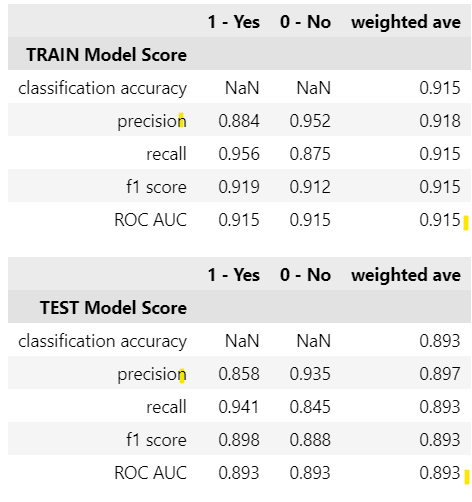
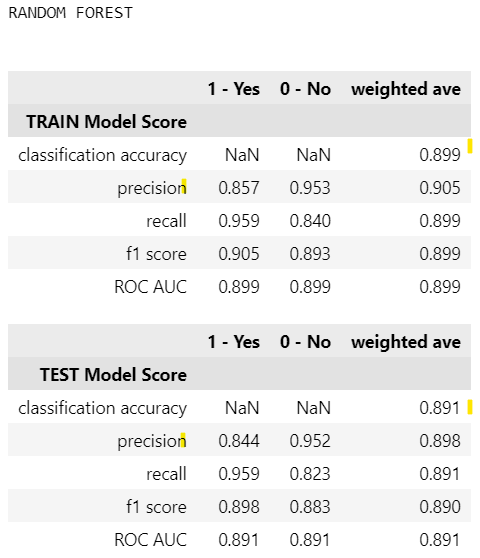

## OVERSAMPLE (months is not encoded)
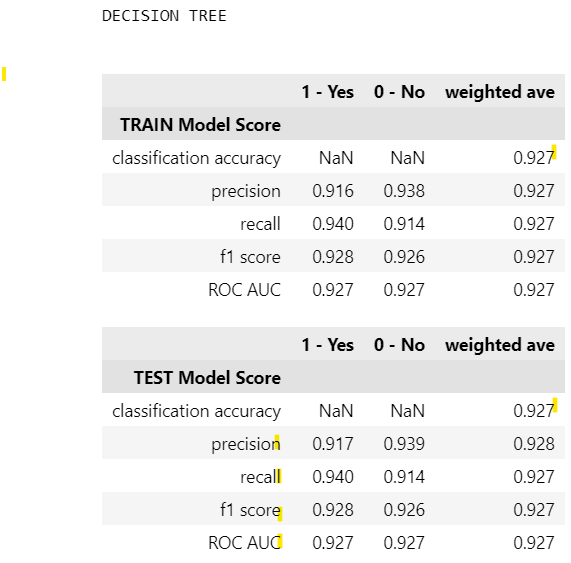
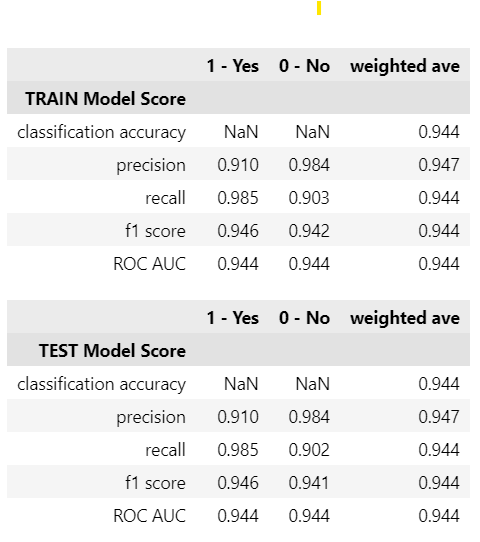

## UNDERSAMPLE
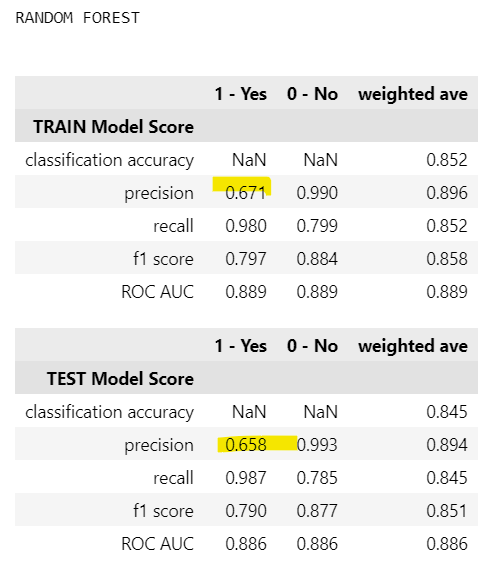

--------------------

# After Split
## NO BALANCING (99.9/.1)
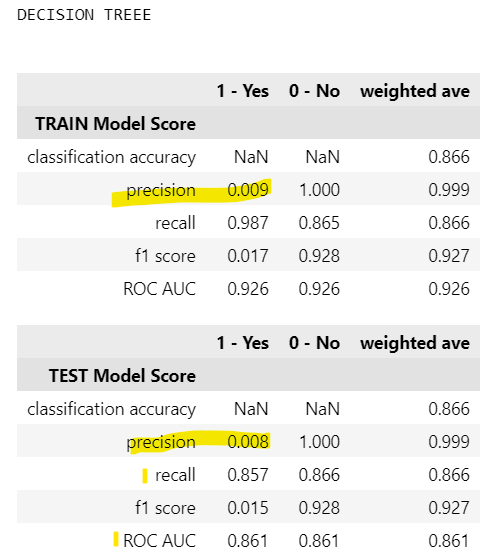
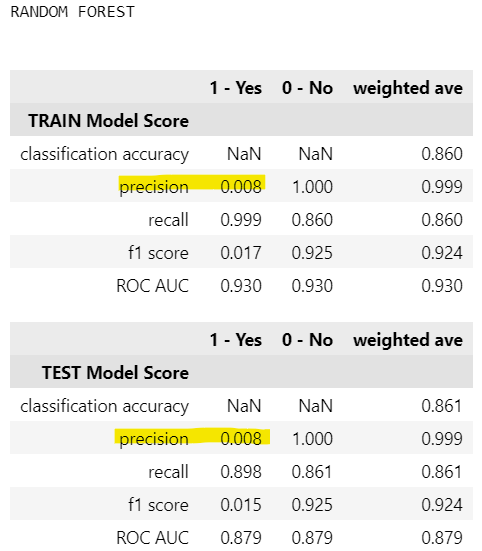

## UNDERSAMPLE (70/30)
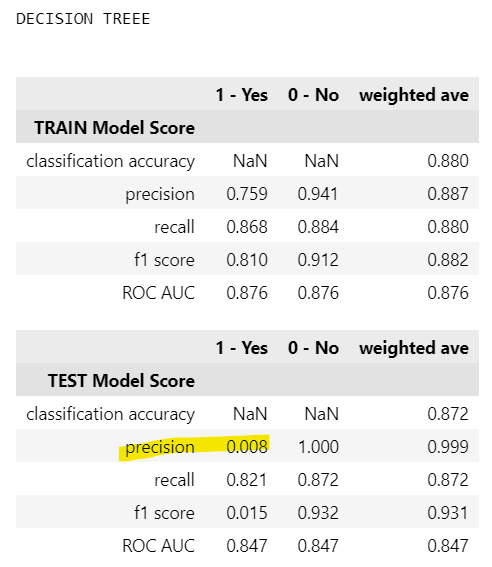
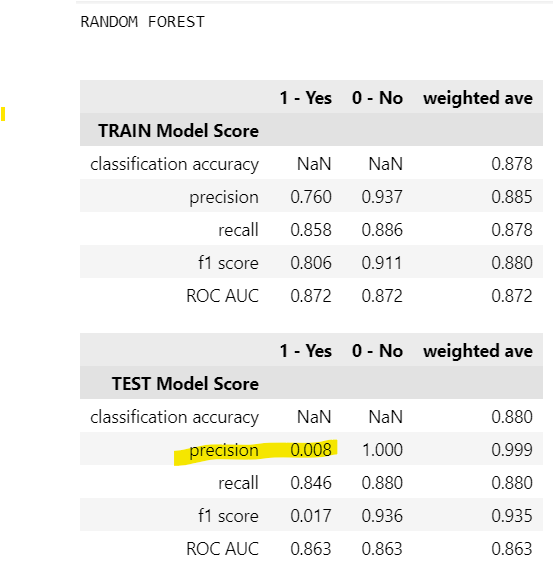

## OVERSAMPLE (50/50)
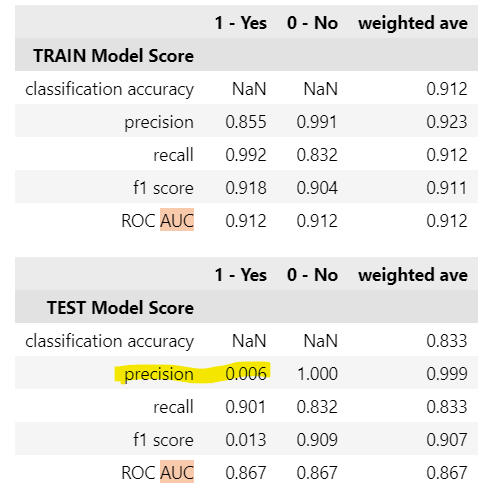

## UNDER+OVER (50/50)
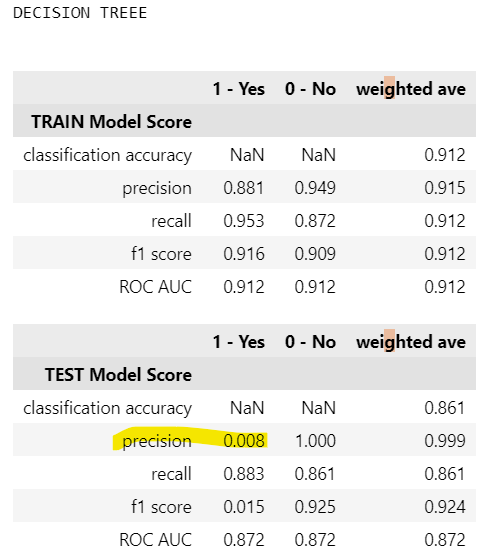
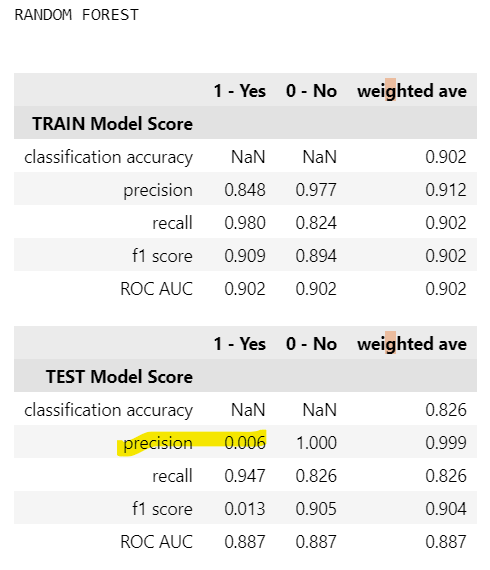

----------------
With Zip and Card

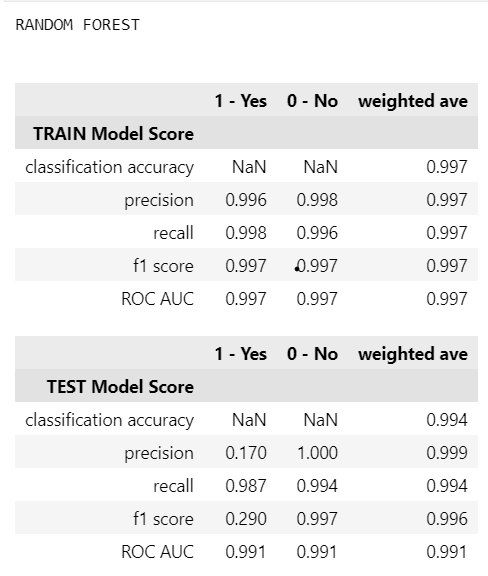 -->


----------
## <center> Pickle File Generation and testing
----------

## Custom Transformer

In [304]:
from sklearn.base import BaseEstimator, TransformerMixin

In [305]:
# Missing Value Merchant City and Zip imputation and update to ONLINE, FOREIGN AND LOCAL 
class GenZipCategoryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,variables=None):
        self.variables = variables
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        # Update all NaN merchant states to ONLINE if City is Online
        X['Merchant State'] = np.where(X['Merchant City']=='ONLINE','ONLINE',X['Merchant State'])

        # Assign Zip as 100 foreign
        X['Zip'] = np.where((X['Merchant State'].notnull()) & (X['Merchant State']!='ONLINE') & (X['Zip'].isnull()),100,X['Zip'])

        # Assign Zip as 0 for online
        X['Zip'] = np.where(X['Zip'].isnull(),0,X['Zip'])

        # Then make all local as 20
        X['Zip']=np.where(X['Zip']>100,20,X['Zip'])

        X.drop(['Merchant State', 'Merchant City'],axis=1, inplace=True)

        return X

In [306]:
# Missing Value Merchant City and Zip imputation and update to ONLINE, FOREIGN AND LOCAL 
class GenMCCGroupTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None):
        self.variables = variables
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X['MCC_Group'] = df_sample.apply(lambda x: self.MCC_Group(x.MCC), axis=1)
        X.drop(columns=['MCC'], inplace=True)
        return X
    
    def MCC_Group(self, MCC):  # Reference: https://www.citibank.com/tts/solutions/commercial-cards/assets/docs/govt/Merchant-Category-Codes.pdf
        if (MCC >= 1) & (MCC <= 1499):
            return "Agricultural Services"
        elif (MCC >= 1500) & (MCC <= 2999):
            return "Contracted Services"
        elif (MCC >= 4000) & (MCC <= 4799):
            return "Transportation Services"
        elif (MCC >= 4800) & (MCC <= 4999):
            return "Utility Services"
        elif (MCC >= 5000) & (MCC <= 5599):
            return "Retail Outlet Services"
        elif (MCC >= 5600) & (MCC <= 5699):
            return "Clothing Stores"
        elif (MCC >= 5700) & (MCC <= 7299):
            return "Miscellaneous Stores"
        elif (MCC >= 7300) & (MCC <= 7999):
            return "Business Services"
        elif (MCC >= 8000) & (MCC <= 8999):
            return "Professional Svcs and Membership Orgs"
        elif (MCC >= 9000) & (MCC <= 9999):
            return "Government Services"
        elif (MCC >= 3000) & (MCC <= 3299):
            return "Airlines"
        elif (MCC >= 3300) & (MCC <= 3499):
            return "Car Rental"
        elif (MCC >= 3500) & (MCC <= 3999):
            return "Lodging"
        else:
            return "Others"

In [307]:
# Get Hour from Time and Change amount to float
class GenHourTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None):
        self.variables = variables
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        # Extract the hours and minutes from Time to perform a more refined time series analysis
        X["Hour"] = X["Time"].str[0:2].astype(int)
        X["Minute"] = X["Time"].str[3:5]

        # Drop Time and Minutes 
        X.drop(['Time', 'Minute'],axis=1, inplace=True)

        X["Amount"]=X["Amount"].str.replace("$","").astype(float)

        return X

In [308]:
# Missing Value Merchant City and Zip imputation and update to ONLINE, FOREIGN AND LOCAL 
class GenDayOfWeekTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None):
        self.variables = variables
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X['Date'] = pd.to_datetime(df_raw[['Year', 'Month', 'Day']])

        X['Day of Week'] = X['Date'].dt.dayofweek

        X.drop(['Year','Date'],axis=1, inplace=True)
        
        return X


In [309]:
# EncodeDummiesTransformer
class EncodeDummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None):
        self.variables = variables
        print(f'EncodeDummiesTransformer: {self.variables}')
        
    def fit(self, X, y=None):
        # One-hot encoding for y 
        X_dummies = pd.get_dummies(X[self.variables ], prefix=self.variables)
        self.X_columns= X_dummies.columns
        return self
    
    def transform(self, X, y=None):
        y=self.variables
        
        X_dummies = pd.get_dummies(X[y], prefix=y)
        X_dummies =X_dummies.reindex(columns=self.X_columns, fill_value=0)

        # Concat the new dummy columns into the dataframe
        X = pd.concat([X, X_dummies], axis=1)

        # Drop the categorical column
        X.drop([y],axis=1, inplace=True)

        return X

## Test custom transformation methods if working properly

In [310]:
# Select a subset of records due to resource limitations
#gohere
df_sample = df_raw[((df_raw['Year']==2019) | (df_raw['Year']==2018) | (df_raw['Year']==2017)) & (df_raw['Errors?'].isnull())] 
print(df_sample.shape)
print(df_sample[df_sample['Is Fraud?']=='Yes'].shape)
# df_sample = df_sample.sample(n=800000, random_state=0)
print(df_sample.shape)
print(df_sample[df_sample['Is Fraud?']=='Yes'].shape)
df_sample['Is Fraud?'] = df_sample['Is Fraud?'].replace({'Yes':1,'No':0})

(5087066, 15)
(4655, 15)
(5087066, 15)
(4655, 15)


In [311]:
df_sample.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?'],
      dtype='object')

In [312]:
df_sample.head(3)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
4338,0,0,2017,1,3,06:56,$28.06,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,NaN,0
4339,0,0,2017,1,4,06:35,$46.07,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912,NaN,0
4340,0,0,2017,1,6,05:47,$31.08,Chip Transaction,4060646732831064559,La Verne,CA,91750.0,5411,NaN,0


In [313]:
# Drop columns not part of user input
model_data = df_sample.drop(['User','Card','Use Chip', 'Merchant Name', 'Errors?'],axis=1)

In [314]:
model_data.columns


Index(['Year', 'Month', 'Day', 'Time', 'Amount', 'Merchant City',
       'Merchant State', 'Zip', 'MCC', 'Is Fraud?'],
      dtype='object')

In [315]:
y_values = model_data.loc[:, model_data.columns == 'Is Fraud?']
X_values = model_data.loc[:, model_data.columns != 'Is Fraud?']

X_train, X_test, y_train, y_test = train_test_split(X_values,y_values,test_size=0.3,random_state=1234, stratify=y_values)


In [316]:
X_train

,Year,Month,Day,Time,Amount,Merchant City,Merchant State,Zip,MCC
7387508,2017,4,9,15:30,$18.10,Daly City,CA,94014.0,4214
5382294,2018,3,21,18:06,$21.95,El Dorado,KS,67042.0,4214
17610015,2019,10,3,19:42,$37.45,Camillus,NY,13031.0,5812
839421,2018,6,29,14:09,$9.39,Concrete,WA,98237.0,5813
19235095,2017,8,18,11:58,$99.00,Chula Vista,CA,91911.0,5541
...,...,...,...,...,...,...,...,...,...
3758359,2019,12,17,13:09,$30.71,ONLINE,NaN,NaN,4121
8338599,2017,11,11,13:26,$87.00,Wellington,OH,44090.0,5499
2330216,2019,2,9,13:56,$44.14,ONLINE,NaN,NaN,5311
8889369,2019,3,4,09:07,$19.95,ONLINE,NaN,NaN,4121


In [317]:
zip_preprocessing = GenZipCategoryTransformer()
mcc_preprocessing = GenMCCGroupTransformer()
time_preprocessing = GenHourTransformer()
dayOfWeek_preprocessing = GenDayOfWeekTransformer()
# dummy_preprocessing = EncodeDummiesTransformer()
dummy_mcc_preprocessing = EncodeDummiesTransformer(variables='MCC_Group')
dummy_zip_preprocessing = EncodeDummiesTransformer(variables='Zip')
dummy_dayOfWeek_preprocessing = EncodeDummiesTransformer(variables='Day of Week')

EncodeDummiesTransformer: MCC_Group
EncodeDummiesTransformer: Zip
EncodeDummiesTransformer: Day of Week


In [318]:
X_transformed = zip_preprocessing.fit_transform(X_train)
X_transformed.head(3)

,Year,Month,Day,Time,Amount,Zip,MCC
7387508,2017,4,9,15:30,$18.10,20.0,4214
5382294,2018,3,21,18:06,$21.95,20.0,4214
17610015,2019,10,3,19:42,$37.45,20.0,5812


In [319]:
X_transformed = mcc_preprocessing.fit_transform(X_transformed)
X_transformed.head(3)

,Year,Month,Day,Time,Amount,Zip,MCC_Group
7387508,2017,4,9,15:30,$18.10,20.0,Transportation Services
5382294,2018,3,21,18:06,$21.95,20.0,Transportation Services
17610015,2019,10,3,19:42,$37.45,20.0,Miscellaneous Stores


In [320]:
X_transformed = time_preprocessing.fit_transform(X_transformed)
X_transformed.head(3)

,Year,Month,Day,Amount,Zip,MCC_Group,Hour
7387508,2017,4,9,18.10,20.0,Transportation Services,15
5382294,2018,3,21,21.95,20.0,Transportation Services,18
17610015,2019,10,3,37.45,20.0,Miscellaneous Stores,19


In [321]:
X_transformed = dayOfWeek_preprocessing.fit_transform(X_transformed)
X_transformed.head(3)

,Month,Day,Amount,Zip,MCC_Group,Hour,Day of Week
7387508,4,9,18.10,20.0,Transportation Services,15,6
5382294,3,21,21.95,20.0,Transportation Services,18,2
17610015,10,3,37.45,20.0,Miscellaneous Stores,19,3


In [322]:
X_transformed = dummy_mcc_preprocessing.fit_transform(X_transformed)
X_transformed.head(3)

,Month,Day,Amount,Zip,Hour,Day of Week,MCC_Group_Airlines,MCC_Group_Business Services,MCC_Group_Car Rental,MCC_Group_Clothing Stores,MCC_Group_Contracted Services,MCC_Group_Government Services,MCC_Group_Lodging,MCC_Group_Miscellaneous Stores,MCC_Group_Professional Svcs and Membership Orgs,MCC_Group_Retail Outlet Services,MCC_Group_Transportation Services,MCC_Group_Utility Services
7387508,4,9,18.10,20.0,15,6,0,0,0,0,0,0,0,0,0,0,1,0
5382294,3,21,21.95,20.0,18,2,0,0,0,0,0,0,0,0,0,0,1,0
17610015,10,3,37.45,20.0,19,3,0,0,0,0,0,0,0,1,0,0,0,0


In [323]:
X_transformed = dummy_dayOfWeek_preprocessing.fit_transform(X_transformed)
X_transformed.head(3)

,Month,Day,Amount,Zip,Hour,MCC_Group_Airlines,MCC_Group_Business Services,MCC_Group_Car Rental,MCC_Group_Clothing Stores,MCC_Group_Contracted Services,...,MCC_Group_Retail Outlet Services,MCC_Group_Transportation Services,MCC_Group_Utility Services,Day of Week_0,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Day of Week_5,Day of Week_6
7387508,4,9,18.10,20.0,15,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
5382294,3,21,21.95,20.0,18,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
17610015,10,3,37.45,20.0,19,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [324]:

X_transformed = dummy_zip_preprocessing.fit_transform(X_transformed)
X_transformed.head(3)

,Month,Day,Amount,Hour,MCC_Group_Airlines,MCC_Group_Business Services,MCC_Group_Car Rental,MCC_Group_Clothing Stores,MCC_Group_Contracted Services,MCC_Group_Government Services,...,Day of Week_0,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Day of Week_5,Day of Week_6,Zip_0.0,Zip_20.0,Zip_100.0
7387508,4,9,18.10,15,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
5382294,3,21,21.95,18,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
17610015,10,3,37.45,19,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [325]:
x_test_trsfrm = zip_preprocessing.transform(X_test)
x_test_trsfrm = mcc_preprocessing.transform(x_test_trsfrm)
x_test_trsfrm = time_preprocessing.transform(x_test_trsfrm)
x_test_trsfrm = dayOfWeek_preprocessing.transform(x_test_trsfrm)
x_test_trsfrm = dummy_mcc_preprocessing.transform(x_test_trsfrm)
x_test_trsfrm = dummy_dayOfWeek_preprocessing.transform(x_test_trsfrm)
x_test_trsfrm = dummy_zip_preprocessing.transform(x_test_trsfrm)
x_test_trsfrm.head(1)

,Month,Day,Amount,Hour,MCC_Group_Airlines,MCC_Group_Business Services,MCC_Group_Car Rental,MCC_Group_Clothing Stores,MCC_Group_Contracted Services,MCC_Group_Government Services,...,Day of Week_0,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Day of Week_5,Day of Week_6,Zip_0.0,Zip_20.0,Zip_100.0
1443887,10,16,1.25,13,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [326]:
y_pred_val = model_dtree.predict(X_transformed)
y_test_pred = model_dtree.predict(x_test_trsfrm)

In [327]:
y_pred_val

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [328]:
#goresult
get_perf_metrics(y_train, y_pred_val, y_test, y_test_pred, 'DECISION TREE')


DECISION TREE



,1 - Yes,0 - No,weighted ave
TRAIN Model Score,,,
classification accuracy,NaN,NaN,1.00
precision,0.24,1.00,1.00
recall,0.94,1.00,1.00
f1 score,0.38,1.00,1.00
ROC AUC,0.97,0.97,0.97


,1 - Yes,0 - No,weighted ave
TEST Model Score,,,
classification accuracy,NaN,NaN,1.00
precision,0.24,1.00,1.00
recall,0.95,1.00,1.00
f1 score,0.38,1.00,1.00
ROC AUC,0.97,0.97,0.97


# Pickle File

In [329]:
import pickle

# Create pickle file for each step
pickle.dump(zip_preprocessing, open("zip_preprocessing.pkl", 'wb'))
pickle.dump(mcc_preprocessing, open("mcc_preprocessing.pkl", 'wb'))
pickle.dump(time_preprocessing, open("time_preprocessing.pkl", 'wb'))
pickle.dump(dayOfWeek_preprocessing, open("dayOfWeek_preprocessing.pkl", 'wb'))
pickle.dump(dummy_mcc_preprocessing, open("dummy_mcc_preprocessing.pkl", 'wb'))
pickle.dump(dummy_dayOfWeek_preprocessing, open("dummy_dayOfWeek_preprocessing.pkl", 'wb'))
pickle.dump(dummy_zip_preprocessing, open("dummy_zip_preprocessing.pkl", 'wb'))
pickle.dump(model_dtree, open("cc_fraud_pipeline_1_model.pkl", 'wb'))


In [330]:
# Loading pickle file
data_zip_preprocessing = pickle.load(open("zip_preprocessing.pkl", 'rb'))
data_mcc_preprocessing = pickle.load(open("mcc_preprocessing.pkl", 'rb'))
data_time_preprocessing = pickle.load(open("time_preprocessing.pkl", 'rb'))
data_dayOfWeek_preprocessing = pickle.load(open("dayOfWeek_preprocessing.pkl", 'rb'))
data_dummy_mcc_preprocessing = pickle.load(open("dummy_mcc_preprocessing.pkl", 'rb'))
data_dummy_dayOfWeek_preprocessing = pickle.load(open("dummy_dayOfWeek_preprocessing.pkl", 'rb'))
data_dummy_zip_preprocessing = pickle.load(open("dummy_zip_preprocessing.pkl", 'rb'))
model_algo_dtree = pickle.load(open("cc_fraud_pipeline_1_model.pkl", 'rb'))

# Testing Pickle file

In [331]:
# Select a subset of records due to resource limitations
#goherefinal
df_sample = df_raw[((df_raw['Year']==2019) | (df_raw['Year']==2018) | (df_raw['Year']==2017)) & (df_raw['Errors?'].isnull())] 
print(df_sample.shape)
print(df_sample[df_sample['Is Fraud?']=='Yes'].shape)
# df_sample = df_sample.sample(n=800000, random_state=0)
print(df_sample.shape)
print(df_sample[df_sample['Is Fraud?']=='Yes'].shape)
df_sample['Is Fraud?'] = df_sample['Is Fraud?'].replace({'Yes':1,'No':0})
y_val = df_sample['Is Fraud?']
df_sample = df_sample.drop(['User','Card','Use Chip', 'Merchant Name', 'Errors?','Is Fraud?'],axis=1)

(5087066, 15)
(4655, 15)
(5087066, 15)
(4655, 15)


In [332]:
df_sample.head(2)

,Year,Month,Day,Time,Amount,Merchant City,Merchant State,Zip,MCC
4338,2017,1,3,06:56,$28.06,Monterey Park,CA,91755.0,5942
4339,2017,1,4,06:35,$46.07,La Verne,CA,91750.0,5912


In [333]:
# df_sample[df_sample['Merchant City']=='Rome']

In [334]:
df_canada = df_sample[df_sample['Merchant City']=='Toronto']
df_italy = df_sample[df_sample['Merchant City']=='Rome']

### Data transformations from pickle

In [335]:
# df_sample_new = df_sample.head(2)
# df_sample_new = df_canada
df_sample_new = df_italy

In [336]:
x_new_trsfrm = data_zip_preprocessing.transform(df_sample_new)
x_new_trsfrm = data_mcc_preprocessing.transform(x_new_trsfrm)
x_new_trsfrm = data_time_preprocessing.transform(x_new_trsfrm)
x_new_trsfrm = data_dayOfWeek_preprocessing.transform(x_new_trsfrm)
x_new_trsfrm = data_dummy_mcc_preprocessing.transform(x_new_trsfrm)
x_new_trsfrm = data_dummy_dayOfWeek_preprocessing.transform(x_new_trsfrm)
x_new_trsfrm = data_dummy_zip_preprocessing.transform(x_new_trsfrm)

### Prediction from pickle

In [337]:
y_new = model_algo_dtree.predict(x_new_trsfrm)
y_new

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [338]:
print(y_new[1:500])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 1 0 0 1 0 1 1 1 1 

# Failed to group into Pipeline and make pickle file work

In [ ]:
Error

In [ ]:
# Select a subset of records due to resource limitations
#goherefinal
df_sample = df_raw[((df_raw['Year']==2019) | (df_raw['Year']==2018) | (df_raw['Year']==2017)) & (df_raw['Errors?'].isnull())] 
print(df_sample.shape)
print(df_sample[df_sample['Is Fraud?']=='Yes'].shape)
# df_sample = df_sample.sample(n=800000, random_state=0)
print(df_sample.shape)
print(df_sample[df_sample['Is Fraud?']=='Yes'].shape)
df_sample['Is Fraud?'] = df_sample['Is Fraud?'].replace({'Yes':1,'No':0})
y_val = df_sample['Is Fraud?']
df_sample = df_sample.drop(['User','Card','Use Chip', 'Merchant Name', 'Errors?','Is Fraud?'],axis=1)

(5087066, 15)
(4655, 15)
(5087066, 15)
(4655, 15)


In [ ]:
df_sample.head(2)

,Year,Month,Day,Time,Amount,Merchant City,Merchant State,Zip,MCC
4338,2017,1,3,06:56,$28.06,Monterey Park,CA,91755.0,5942
4339,2017,1,4,06:35,$46.07,La Verne,CA,91750.0,5912


In [ ]:
df_sample_2 =df_sample.head(2)

In [ ]:
df_sample_2

,Year,Month,Day,Time,Amount,Merchant City,Merchant State,Zip,MCC
4338,2017,1,3,06:56,$28.06,Monterey Park,CA,91755.0,5942
4339,2017,1,4,06:35,$46.07,La Verne,CA,91750.0,5912


In [ ]:
zip_preprocessing = GenZipCategoryTransformer()
mcc_preprocessing = GenMCCGroupTransformer()
time_preprocessing = GenHourTransformer()
dayOfWeek_preprocessing = GenDayOfWeekTransformer()
dummy_mcc_preprocessing = EncodeDummiesTransformer(variables='MCC_Group')
dummy_dayOfWeek_preprocessing = EncodeDummiesTransformer(variables='Day of Week')
dummy_zip_preprocessing = EncodeDummiesTransformer(variables='Zip')

EncodeDummiesTransformer: MCC_Group
EncodeDummiesTransformer: Day of Week
EncodeDummiesTransformer: Zip


In [ ]:
combined_preprocessing_pipe = Pipeline(
    steps=[
        ('zip_preprocessing', zip_preprocessing),
        ('mcc_preprocessing', mcc_preprocessing),
        ('time_preprocessing', time_preprocessing),
        ('dayOfWeek_preprocessing', dayOfWeek_preprocessing),
        ('dummy_mcc_preprocessing', dummy_mcc_preprocessing),
        ('dummy_dayOfWeek_preprocessing', dummy_dayOfWeek_preprocessing),
        ('dummy_zip_preprocessing', dummy_zip_preprocessing),
    ]
)

In [ ]:
import joblib
# from sklearn.externals import joblib

pipeline = Pipeline([
        ('preprocessing', combined_preprocessing_pipe)
        # ('Model Training', model_dtree)
    ])

transformed = pipeline.fit_transform(df_sample)

# joblib.dump(pipeline, 'cc_fraud_pipeline.pkl')

Index(['MCC_Group_Airlines', 'MCC_Group_Business Services',
       'MCC_Group_Car Rental', 'MCC_Group_Clothing Stores',
       'MCC_Group_Contracted Services', 'MCC_Group_Government Services',
       'MCC_Group_Lodging', 'MCC_Group_Miscellaneous Stores',
       'MCC_Group_Professional Svcs and Membership Orgs',
       'MCC_Group_Retail Outlet Services', 'MCC_Group_Transportation Services',
       'MCC_Group_Utility Services'],
      dtype='object')
EncodeDummiesTransformer: MCC_Group
Encoding feature:
MCC_Group
Index(['Day of Week_0', 'Day of Week_1', 'Day of Week_2', 'Day of Week_3',
       'Day of Week_4', 'Day of Week_5', 'Day of Week_6'],
      dtype='object')
EncodeDummiesTransformer: Day of Week
Encoding feature:
Day of Week
Index(['Zip_0.0', 'Zip_20.0', 'Zip_100.0'], dtype='object')
EncodeDummiesTransformer: Zip
Encoding feature:
Zip


In [ ]:
transformed.head(2)

,Month,Day,Amount,Hour,MCC_Group_Airlines,MCC_Group_Business Services,MCC_Group_Car Rental,MCC_Group_Clothing Stores,MCC_Group_Contracted Services,MCC_Group_Government Services,...,Day of Week_0,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Day of Week_5,Day of Week_6,Zip_0.0,Zip_20.0,Zip_100.0
4338,1,3,28.06,6,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4339,1,4,46.07,6,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
df_sample_2_backup = df_sample_2
df_sample_2.head(2)

,Year,Month,Day,Time,Amount,Merchant City,Merchant State,Zip,MCC
4338,2017,1,3,06:56,$28.06,Monterey Park,CA,91755.0,5942
4339,2017,1,4,06:35,$46.07,La Verne,CA,91750.0,5912


In [ ]:
transform_nofit = pipeline[:3].fit_transform(df_sample_2)
transform_nofit.head()

AttributeError: 'Series' object has no attribute 'MCC'

In [ ]:
transformed.head(5)

In [ ]:
model_dtree = DecisionTreeClassifier(random_state = 1234, min_samples_leaf=min_samples_leaf, max_depth=max_depth, class_weight=class_weight)
model_dtree.fit(transformed, y_val)

In [ ]:
y_pred_train_dtree = model_dtree.predict(transformed)
y_pred_train_dtree

In [ ]:
import pickle
pickle.dump(pipeline, open("cc_fraud_pipeline_1_processing.pkl", 'wb'))
pickle.dump(model_dtree, open("cc_fraud_pipeline_1_model.pkl", 'wb'))

In [ ]:
data_processor = pickle.load(open("cc_fraud_pipeline_1_processing.pkl", 'rb'))
data_dtree = pickle.load(open("cc_fraud_pipeline_1_model.pkl", 'rb'))

In [ ]:
X_new = df_sample_2
X_new_transformed = data_processor.transform(X_new)
X_new_transformed

In [ ]:
Y_new_transformed = data_dtree.predict(X_new_transformed)